# DQN

---

In [ ]:
import os, sys, random, time
import warnings

import numpy as np
import torch
import matplotlib.pyplot as plt

import gymnasium as gym
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor

import imageio
from IPython.display import Image

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED) # to assure reproducibility on numpy (affects functions like np.random.rand, np.random.shuffle, etc.)
torch.manual_seed(SEED)  # to assure reproducibility on Torch (affects weight initialization, dropout, data shuffling, etc.)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.cuda.manual_seed_all(SEED) # usefull when using more than one GPT, otherwise torch.manual_seed is enough

# Ensure deterministic behavior in CuDNN (NVIDIA backend for deep learning ops).
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
OUT_DIR = './outputs_DQN/'
os.makedirs(OUT_DIR, exist_ok=True)

TENSORBOARD_LOGS_DIR = OUT_DIR + "tensorboard/"
SAVE_MODEL_PATH = OUT_DIR + "model_dqn.zip"

MODEL_NAME = "LunarLander-v3"
MLP_POLICY = "MlpPolicy"

env = gym.make(MODEL_NAME)
env.reset(seed=SEED)

# Select device: use GPU if available, otherwise fallback to CPU
# This will be very important do control in which device the processing will happen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Python:", sys.version.split()[0])
print("PyTorch:", torch.__version__)
print("Device:", device)
print("CUDA:", torch.version.cuda if torch.cuda.is_available() else "None")

Python: 3.12.3
PyTorch: 2.10.0+cu130
Device: cuda
CUDA: 13.0


In [4]:
def make_env():
    """Factory function that creates a fresh LunarLander environment."""
    return gym.make(MODEL_NAME)

env = DummyVecEnv([make_env])

In [5]:
"""
model_dqn = DQN(
    policy=MLP_POLICY,
    env=env,
    exploration_fraction=0.12,
    learning_rate=6.3e-4,
    buffer_size=50_000,
    batch_size=128,
    gamma=0.99,
    # Number of timesteps to collect before the first training update. 
    # During the first 500 steps, the agent only explores and fills the replay buffer.
    learning_starts=0,
    # Frequency (in timesteps) at which the target network is updated copying the weights from the main Q-network
    target_update_interval=250,
    # How often to perform a gradient update.
    # With train_freq=4, the network is updated once every 4 environment steps.
    train_freq=4,

    verbose=1,  # verbose 0 for disable logs
    seed=SEED,
    tensorboard_log=TENSORBOARD_LOGS_DIR,
)
"""

'\nmodel_dqn = DQN(\n    policy=MLP_POLICY,\n    env=env,\n    exploration_fraction=0.12,\n    learning_rate=6.3e-4,\n    buffer_size=50_000,\n    batch_size=128,\n    gamma=0.99,\n    # Number of timesteps to collect before the first training update. \n    # During the first 500 steps, the agent only explores and fills the replay buffer.\n    learning_starts=0,\n    # Frequency (in timesteps) at which the target network is updated copying the weights from the main Q-network\n    target_update_interval=250,\n    # How often to perform a gradient update.\n    # With train_freq=4, the network is updated once every 4 environment steps.\n    train_freq=4,\n\n    verbose=1,  # verbose 0 for disable logs\n    seed=SEED,\n    tensorboard_log=TENSORBOARD_LOGS_DIR,\n)\n'

In [6]:
model_dqn = DQN(
    policy=MLP_POLICY,
    env=env,
    exploration_fraction=0.12,
    exploration_final_eps=0.02,
    learning_rate=6.3e-4,
    buffer_size=50_000,
    batch_size=128,
    gamma=0.99,
    # Number of timesteps to collect before the first training update. 
    # During the first 500 steps, the agent only explores and fills the replay buffer.
    learning_starts=0,
    # Frequency (in timesteps) at which the target network is updated copying the weights from the main Q-network
    target_update_interval=250,
    # How often to perform a gradient update.
    # With train_freq=4, the network is updated once every 4 environment steps.
    train_freq=4,

    verbose=1,  # verbose 0 for disable logs
    seed=SEED,
    tensorboard_log=TENSORBOARD_LOGS_DIR,
)

Using cuda device


In [7]:
class DQNLoggingCallback(BaseCallback):
    """
    Custom callback for logging exploration-related metrics during training.

    This callback tracks:
    - The exploration rate (epsilon) over time
    - Episode rewards (one value per completed episode)
    - The number of gradient update steps performed by the agent

    The data collected here will later be used to plot training curves directly inside the notebook, complementing (but not replacing) TensorBoard.
    """
    def __init__(self, verbose=0):
        super().__init__(verbose)
        # list to store the metrics
        self.epsilon_history = []
        self.reward_history = []
        self.update_steps = []
        self.episode_reward = 0

    def _on_step(self) -> bool:
        # epsilon info
        if hasattr(self.model, "exploration_rate"):
            self.epsilon_history.append(self.model.exploration_rate)

        # reward info
        reward = self.locals.get("rewards")
        if reward is not None:
            self.episode_reward += reward[0]

        # check if episode has end (done)
        done = self.locals.get("dones")
        if done is not None and done[0]:
            self.reward_history.append(self.episode_reward)
            self.episode_reward = 0 # reset for next episode

        # number of gradient updates performed
        self.update_steps.append(self.model._n_updates)

        return True

In [8]:
#instanciate the callback for training metrics logging
callback = DQNLoggingCallback()

model_dqn.learn(
    # total_timesteps=500_000,
    total_timesteps=750_000,
    callback = callback,
    progress_bar=True)

Logging to ./outputs_DQN/tensorboard/DQN_5


Output()

----------------------------------
| rollout/            |          |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 885      |
|    time_elapsed     | 0        |
|    total_timesteps  | 388      |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.78     |
|    n_updates        | 96       |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.992    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1221     |
|    time_elapsed     | 0        |
|    total_timesteps  | 777      |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 3.42     |
|    n_updates        | 194      |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.987    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 1402     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1183     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.28     |
|    n_updates        | 295      |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.983    |
| time/               |          |
|    episodes         | 16       |
|    fps              | 1488     |
|    time_elapsed     | 1        |
|    total_timesteps  | 1570     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.07     |
|    n_updates        | 392      |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.979    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 1550     |
|    time_elapsed     | 1        |
|    total_timesteps  | 1890     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.58     |
|    n_updates        | 472      |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.976    |
| time/               |          |
|    episodes         | 24       |
|    fps              | 1601     |
|    time_elapsed     | 1        |
|    total_timesteps  | 2230     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 3.25     |
|    n_updates        | 557      |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.972    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 1627     |
|    time_elapsed     | 1        |
|    total_timesteps  | 2612     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.87     |
|    n_updates        | 652      |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.968    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 1650     |
|    time_elapsed     | 1        |
|    total_timesteps  | 2907     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.68     |
|    n_updates        | 726      |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.963    |
| time/               |          |
|    episodes         | 36       |
|    fps              | 1660     |
|    time_elapsed     | 2        |
|    total_timesteps  | 3366     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.884    |
|    n_updates        | 841      |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.96     |
| time/               |          |
|    episodes         | 40       |
|    fps              | 1658     |
|    time_elapsed     | 2        |
|    total_timesteps  | 3692     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.957    |
|    n_updates        | 922      |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.956    |
| time/               |          |
|    episodes         | 44       |
|    fps              | 1658     |
|    time_elapsed     | 2        |
|    total_timesteps  | 4085     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.49     |
|    n_updates        | 1021     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.952    |
| time/               |          |
|    episodes         | 48       |
|    fps              | 1674     |
|    time_elapsed     | 2        |
|    total_timesteps  | 4403     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 3.46     |
|    n_updates        | 1100     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.948    |
| time/               |          |
|    episodes         | 52       |
|    fps              | 1686     |
|    time_elapsed     | 2        |
|    total_timesteps  | 4735     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.96     |
|    n_updates        | 1183     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.944    |
| time/               |          |
|    episodes         | 56       |
|    fps              | 1695     |
|    time_elapsed     | 3        |
|    total_timesteps  | 5125     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.17     |
|    n_updates        | 1281     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.94     |
| time/               |          |
|    episodes         | 60       |
|    fps              | 1694     |
|    time_elapsed     | 3        |
|    total_timesteps  | 5529     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.94     |
|    n_updates        | 1382     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.935    |
| time/               |          |
|    episodes         | 64       |
|    fps              | 1706     |
|    time_elapsed     | 3        |
|    total_timesteps  | 5939     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.51     |
|    n_updates        | 1484     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.931    |
| time/               |          |
|    episodes         | 68       |
|    fps              | 1713     |
|    time_elapsed     | 3        |
|    total_timesteps  | 6328     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 4.13     |
|    n_updates        | 1581     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.927    |
| time/               |          |
|    episodes         | 72       |
|    fps              | 1719     |
|    time_elapsed     | 3        |
|    total_timesteps  | 6675     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.26     |
|    n_updates        | 1668     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.924    |
| time/               |          |
|    episodes         | 76       |
|    fps              | 1726     |
|    time_elapsed     | 4        |
|    total_timesteps  | 6965     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.03     |
|    n_updates        | 1741     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.92     |
| time/               |          |
|    episodes         | 80       |
|    fps              | 1732     |
|    time_elapsed     | 4        |
|    total_timesteps  | 7373     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.39     |
|    n_updates        | 1843     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.916    |
| time/               |          |
|    episodes         | 84       |
|    fps              | 1730     |
|    time_elapsed     | 4        |
|    total_timesteps  | 7731     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 5.38     |
|    n_updates        | 1932     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.913    |
| time/               |          |
|    episodes         | 88       |
|    fps              | 1733     |
|    time_elapsed     | 4        |
|    total_timesteps  | 8035     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 3.91     |
|    n_updates        | 2008     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.908    |
| time/               |          |
|    episodes         | 92       |
|    fps              | 1725     |
|    time_elapsed     | 4        |
|    total_timesteps  | 8427     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 3.13     |
|    n_updates        | 2106     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.903    |
| time/               |          |
|    episodes         | 96       |
|    fps              | 1722     |
|    time_elapsed     | 5        |
|    total_timesteps  | 8891     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.45     |
|    n_updates        | 2222     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.9      |
| time/               |          |
|    episodes         | 100      |
|    fps              | 1723     |
|    time_elapsed     | 5        |
|    total_timesteps  | 9224     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.45     |
|    n_updates        | 2305     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.896    |
| time/               |          |
|    episodes         | 104      |
|    fps              | 1724     |
|    time_elapsed     | 5        |
|    total_timesteps  | 9589     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 5.2      |
|    n_updates        | 2397     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.892    |
| time/               |          |
|    episodes         | 108      |
|    fps              | 1727     |
|    time_elapsed     | 5        |
|    total_timesteps  | 9957     |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 5.47     |
|    n_updates        | 2489     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.888    |
| time/               |          |
|    episodes         | 112      |
|    fps              | 1731     |
|    time_elapsed     | 5        |
|    total_timesteps  | 10327    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.66     |
|    n_updates        | 2581     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.884    |
| time/               |          |
|    episodes         | 116      |
|    fps              | 1733     |
|    time_elapsed     | 6        |
|    total_timesteps  | 10693    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.579    |
|    n_updates        | 2673     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.88     |
| time/               |          |
|    episodes         | 120      |
|    fps              | 1736     |
|    time_elapsed     | 6        |
|    total_timesteps  | 11039    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.73     |
|    n_updates        | 2759     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.876    |
| time/               |          |
|    episodes         | 124      |
|    fps              | 1737     |
|    time_elapsed     | 6        |
|    total_timesteps  | 11405    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.37     |
|    n_updates        | 2851     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.872    |
| time/               |          |
|    episodes         | 128      |
|    fps              | 1740     |
|    time_elapsed     | 6        |
|    total_timesteps  | 11798    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 4.2      |
|    n_updates        | 2949     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.867    |
| time/               |          |
|    episodes         | 132      |
|    fps              | 1739     |
|    time_elapsed     | 7        |
|    total_timesteps  | 12198    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.92     |
|    n_updates        | 3049     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.863    |
| time/               |          |
|    episodes         | 136      |
|    fps              | 1739     |
|    time_elapsed     | 7        |
|    total_timesteps  | 12584    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.13     |
|    n_updates        | 3145     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.858    |
| time/               |          |
|    episodes         | 140      |
|    fps              | 1737     |
|    time_elapsed     | 7        |
|    total_timesteps  | 13025    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.7      |
|    n_updates        | 3256     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.854    |
| time/               |          |
|    episodes         | 144      |
|    fps              | 1739     |
|    time_elapsed     | 7        |
|    total_timesteps  | 13378    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.3      |
|    n_updates        | 3344     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.851    |
| time/               |          |
|    episodes         | 148      |
|    fps              | 1740     |
|    time_elapsed     | 7        |
|    total_timesteps  | 13714    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.56     |
|    n_updates        | 3428     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.847    |
| time/               |          |
|    episodes         | 152      |
|    fps              | 1739     |
|    time_elapsed     | 8        |
|    total_timesteps  | 14081    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.716    |
|    n_updates        | 3520     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.842    |
| time/               |          |
|    episodes         | 156      |
|    fps              | 1738     |
|    time_elapsed     | 8        |
|    total_timesteps  | 14490    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.74     |
|    n_updates        | 3622     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.838    |
| time/               |          |
|    episodes         | 160      |
|    fps              | 1737     |
|    time_elapsed     | 8        |
|    total_timesteps  | 14895    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.63     |
|    n_updates        | 3723     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.833    |
| time/               |          |
|    episodes         | 164      |
|    fps              | 1737     |
|    time_elapsed     | 8        |
|    total_timesteps  | 15294    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 7.66     |
|    n_updates        | 3823     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.83     |
| time/               |          |
|    episodes         | 168      |
|    fps              | 1735     |
|    time_elapsed     | 9        |
|    total_timesteps  | 15644    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 4.17     |
|    n_updates        | 3910     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.826    |
| time/               |          |
|    episodes         | 172      |
|    fps              | 1732     |
|    time_elapsed     | 9        |
|    total_timesteps  | 15942    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.17     |
|    n_updates        | 3985     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.822    |
| time/               |          |
|    episodes         | 176      |
|    fps              | 1731     |
|    time_elapsed     | 9        |
|    total_timesteps  | 16302    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.39     |
|    n_updates        | 4075     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.817    |
| time/               |          |
|    episodes         | 180      |
|    fps              | 1729     |
|    time_elapsed     | 9        |
|    total_timesteps  | 16787    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 7.71     |
|    n_updates        | 4196     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.814    |
| time/               |          |
|    episodes         | 184      |
|    fps              | 1729     |
|    time_elapsed     | 9        |
|    total_timesteps  | 17125    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.683    |
|    n_updates        | 4281     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.809    |
| time/               |          |
|    episodes         | 188      |
|    fps              | 1727     |
|    time_elapsed     | 10       |
|    total_timesteps  | 17565    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.56     |
|    n_updates        | 4391     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.805    |
| time/               |          |
|    episodes         | 192      |
|    fps              | 1727     |
|    time_elapsed     | 10       |
|    total_timesteps  | 17926    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.48     |
|    n_updates        | 4481     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.801    |
| time/               |          |
|    episodes         | 196      |
|    fps              | 1725     |
|    time_elapsed     | 10       |
|    total_timesteps  | 18307    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 4.49     |
|    n_updates        | 4576     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.795    |
| time/               |          |
|    episodes         | 200      |
|    fps              | 1720     |
|    time_elapsed     | 10       |
|    total_timesteps  | 18811    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.62     |
|    n_updates        | 4702     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.791    |
| time/               |          |
|    episodes         | 204      |
|    fps              | 1716     |
|    time_elapsed     | 11       |
|    total_timesteps  | 19239    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 7.93     |
|    n_updates        | 4809     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.786    |
| time/               |          |
|    episodes         | 208      |
|    fps              | 1712     |
|    time_elapsed     | 11       |
|    total_timesteps  | 19660    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.736    |
|    n_updates        | 4914     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.782    |
| time/               |          |
|    episodes         | 212      |
|    fps              | 1710     |
|    time_elapsed     | 11       |
|    total_timesteps  | 20041    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 5.79     |
|    n_updates        | 5010     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.778    |
| time/               |          |
|    episodes         | 216      |
|    fps              | 1703     |
|    time_elapsed     | 11       |
|    total_timesteps  | 20432    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.19     |
|    n_updates        | 5107     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.773    |
| time/               |          |
|    episodes         | 220      |
|    fps              | 1700     |
|    time_elapsed     | 12       |
|    total_timesteps  | 20824    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.44     |
|    n_updates        | 5205     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.768    |
| time/               |          |
|    episodes         | 224      |
|    fps              | 1696     |
|    time_elapsed     | 12       |
|    total_timesteps  | 21297    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 4.01     |
|    n_updates        | 5324     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.763    |
| time/               |          |
|    episodes         | 228      |
|    fps              | 1693     |
|    time_elapsed     | 12       |
|    total_timesteps  | 21756    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.71     |
|    n_updates        | 5438     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.758    |
| time/               |          |
|    episodes         | 232      |
|    fps              | 1689     |
|    time_elapsed     | 13       |
|    total_timesteps  | 22201    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 4.02     |
|    n_updates        | 5550     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.754    |
| time/               |          |
|    episodes         | 236      |
|    fps              | 1685     |
|    time_elapsed     | 13       |
|    total_timesteps  | 22574    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 6.37     |
|    n_updates        | 5643     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.749    |
| time/               |          |
|    episodes         | 240      |
|    fps              | 1680     |
|    time_elapsed     | 13       |
|    total_timesteps  | 23017    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.43     |
|    n_updates        | 5754     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.745    |
| time/               |          |
|    episodes         | 244      |
|    fps              | 1679     |
|    time_elapsed     | 13       |
|    total_timesteps  | 23452    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.7      |
|    n_updates        | 5862     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.739    |
| time/               |          |
|    episodes         | 248      |
|    fps              | 1676     |
|    time_elapsed     | 14       |
|    total_timesteps  | 23937    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.13     |
|    n_updates        | 5984     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.735    |
| time/               |          |
|    episodes         | 252      |
|    fps              | 1672     |
|    time_elapsed     | 14       |
|    total_timesteps  | 24357    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.55     |
|    n_updates        | 6089     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.731    |
| time/               |          |
|    episodes         | 256      |
|    fps              | 1669     |
|    time_elapsed     | 14       |
|    total_timesteps  | 24739    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.42     |
|    n_updates        | 6184     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.726    |
| time/               |          |
|    episodes         | 260      |
|    fps              | 1667     |
|    time_elapsed     | 15       |
|    total_timesteps  | 25180    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 6.67     |
|    n_updates        | 6294     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.722    |
| time/               |          |
|    episodes         | 264      |
|    fps              | 1663     |
|    time_elapsed     | 15       |
|    total_timesteps  | 25574    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.688    |
|    n_updates        | 6393     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.716    |
| time/               |          |
|    episodes         | 268      |
|    fps              | 1660     |
|    time_elapsed     | 15       |
|    total_timesteps  | 26068    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 4.36     |
|    n_updates        | 6516     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.712    |
| time/               |          |
|    episodes         | 272      |
|    fps              | 1658     |
|    time_elapsed     | 15       |
|    total_timesteps  | 26455    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.92     |
|    n_updates        | 6613     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.707    |
| time/               |          |
|    episodes         | 276      |
|    fps              | 1655     |
|    time_elapsed     | 16       |
|    total_timesteps  | 26920    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.12     |
|    n_updates        | 6729     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.703    |
| time/               |          |
|    episodes         | 280      |
|    fps              | 1653     |
|    time_elapsed     | 16       |
|    total_timesteps  | 27292    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.61     |
|    n_updates        | 6822     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.698    |
| time/               |          |
|    episodes         | 284      |
|    fps              | 1650     |
|    time_elapsed     | 16       |
|    total_timesteps  | 27731    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.59     |
|    n_updates        | 6932     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.693    |
| time/               |          |
|    episodes         | 288      |
|    fps              | 1646     |
|    time_elapsed     | 17       |
|    total_timesteps  | 28199    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.21     |
|    n_updates        | 7049     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.688    |
| time/               |          |
|    episodes         | 292      |
|    fps              | 1644     |
|    time_elapsed     | 17       |
|    total_timesteps  | 28650    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 3.11     |
|    n_updates        | 7162     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.683    |
| time/               |          |
|    episodes         | 296      |
|    fps              | 1641     |
|    time_elapsed     | 17       |
|    total_timesteps  | 29114    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.38     |
|    n_updates        | 7278     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.679    |
| time/               |          |
|    episodes         | 300      |
|    fps              | 1639     |
|    time_elapsed     | 18       |
|    total_timesteps  | 29524    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.7      |
|    n_updates        | 7380     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.673    |
| time/               |          |
|    episodes         | 304      |
|    fps              | 1635     |
|    time_elapsed     | 18       |
|    total_timesteps  | 29986    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 3.95     |
|    n_updates        | 7496     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.665    |
| time/               |          |
|    episodes         | 308      |
|    fps              | 1630     |
|    time_elapsed     | 18       |
|    total_timesteps  | 30761    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.88     |
|    n_updates        | 7690     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.66     |
| time/               |          |
|    episodes         | 312      |
|    fps              | 1628     |
|    time_elapsed     | 19       |
|    total_timesteps  | 31243    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.86     |
|    n_updates        | 7810     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.655    |
| time/               |          |
|    episodes         | 316      |
|    fps              | 1626     |
|    time_elapsed     | 19       |
|    total_timesteps  | 31638    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 4.22     |
|    n_updates        | 7909     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.651    |
| time/               |          |
|    episodes         | 320      |
|    fps              | 1620     |
|    time_elapsed     | 19       |
|    total_timesteps  | 32080    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 4.99     |
|    n_updates        | 8019     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.646    |
| time/               |          |
|    episodes         | 324      |
|    fps              | 1616     |
|    time_elapsed     | 20       |
|    total_timesteps  | 32482    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.89     |
|    n_updates        | 8120     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.641    |
| time/               |          |
|    episodes         | 328      |
|    fps              | 1613     |
|    time_elapsed     | 20       |
|    total_timesteps  | 32941    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 4.51     |
|    n_updates        | 8235     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.627    |
| time/               |          |
|    episodes         | 332      |
|    fps              | 1602     |
|    time_elapsed     | 21       |
|    total_timesteps  | 34301    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.68     |
|    n_updates        | 8575     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.622    |
| time/               |          |
|    episodes         | 336      |
|    fps              | 1597     |
|    time_elapsed     | 21       |
|    total_timesteps  | 34712    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 3.03     |
|    n_updates        | 8677     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.617    |
| time/               |          |
|    episodes         | 340      |
|    fps              | 1595     |
|    time_elapsed     | 22       |
|    total_timesteps  | 35200    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 3.29     |
|    n_updates        | 8799     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.612    |
| time/               |          |
|    episodes         | 344      |
|    fps              | 1586     |
|    time_elapsed     | 22       |
|    total_timesteps  | 35665    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 6.7      |
|    n_updates        | 8916     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.607    |
| time/               |          |
|    episodes         | 348      |
|    fps              | 1583     |
|    time_elapsed     | 22       |
|    total_timesteps  | 36060    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 12.3     |
|    n_updates        | 9014     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.602    |
| time/               |          |
|    episodes         | 352      |
|    fps              | 1580     |
|    time_elapsed     | 23       |
|    total_timesteps  | 36591    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 4.24     |
|    n_updates        | 9147     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.595    |
| time/               |          |
|    episodes         | 356      |
|    fps              | 1573     |
|    time_elapsed     | 23       |
|    total_timesteps  | 37237    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 4.05     |
|    n_updates        | 9309     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.59     |
| time/               |          |
|    episodes         | 360      |
|    fps              | 1572     |
|    time_elapsed     | 23       |
|    total_timesteps  | 37690    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.46     |
|    n_updates        | 9422     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.585    |
| time/               |          |
|    episodes         | 364      |
|    fps              | 1570     |
|    time_elapsed     | 24       |
|    total_timesteps  | 38149    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 7.19     |
|    n_updates        | 9537     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.579    |
| time/               |          |
|    episodes         | 368      |
|    fps              | 1568     |
|    time_elapsed     | 24       |
|    total_timesteps  | 38620    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 3.56     |
|    n_updates        | 9654     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.573    |
| time/               |          |
|    episodes         | 372      |
|    fps              | 1561     |
|    time_elapsed     | 25       |
|    total_timesteps  | 39200    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 8.41     |
|    n_updates        | 9799     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.566    |
| time/               |          |
|    episodes         | 376      |
|    fps              | 1557     |
|    time_elapsed     | 25       |
|    total_timesteps  | 39825    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 6.97     |
|    n_updates        | 9956     |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.561    |
| time/               |          |
|    episodes         | 380      |
|    fps              | 1554     |
|    time_elapsed     | 25       |
|    total_timesteps  | 40317    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 4.76     |
|    n_updates        | 10079    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.555    |
| time/               |          |
|    episodes         | 384      |
|    fps              | 1552     |
|    time_elapsed     | 26       |
|    total_timesteps  | 40844    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 4.66     |
|    n_updates        | 10210    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.55     |
| time/               |          |
|    episodes         | 388      |
|    fps              | 1549     |
|    time_elapsed     | 26       |
|    total_timesteps  | 41307    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 4.12     |
|    n_updates        | 10326    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.545    |
| time/               |          |
|    episodes         | 392      |
|    fps              | 1545     |
|    time_elapsed     | 27       |
|    total_timesteps  | 41757    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.46     |
|    n_updates        | 10439    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.538    |
| time/               |          |
|    episodes         | 396      |
|    fps              | 1542     |
|    time_elapsed     | 27       |
|    total_timesteps  | 42385    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 4.49     |
|    n_updates        | 10596    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.532    |
| time/               |          |
|    episodes         | 400      |
|    fps              | 1537     |
|    time_elapsed     | 27       |
|    total_timesteps  | 42981    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 3.85     |
|    n_updates        | 10745    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.52     |
| time/               |          |
|    episodes         | 404      |
|    fps              | 1529     |
|    time_elapsed     | 28       |
|    total_timesteps  | 44070    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.3      |
|    n_updates        | 11017    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.514    |
| time/               |          |
|    episodes         | 408      |
|    fps              | 1526     |
|    time_elapsed     | 29       |
|    total_timesteps  | 44597    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 10.6     |
|    n_updates        | 11149    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.506    |
| time/               |          |
|    episodes         | 412      |
|    fps              | 1522     |
|    time_elapsed     | 29       |
|    total_timesteps  | 45370    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 7.61     |
|    n_updates        | 11342    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.5      |
| time/               |          |
|    episodes         | 416      |
|    fps              | 1519     |
|    time_elapsed     | 30       |
|    total_timesteps  | 45944    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.48     |
|    n_updates        | 11485    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.493    |
| time/               |          |
|    episodes         | 420      |
|    fps              | 1515     |
|    time_elapsed     | 30       |
|    total_timesteps  | 46584    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 10.3     |
|    n_updates        | 11645    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.48     |
| time/               |          |
|    episodes         | 424      |
|    fps              | 1509     |
|    time_elapsed     | 31       |
|    total_timesteps  | 47777    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 5.79     |
|    n_updates        | 11944    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.468    |
| time/               |          |
|    episodes         | 428      |
|    fps              | 1503     |
|    time_elapsed     | 32       |
|    total_timesteps  | 48848    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 3.91     |
|    n_updates        | 12211    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.453    |
| time/               |          |
|    episodes         | 432      |
|    fps              | 1496     |
|    time_elapsed     | 33       |
|    total_timesteps  | 50260    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 3.85     |
|    n_updates        | 12564    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.438    |
| time/               |          |
|    episodes         | 436      |
|    fps              | 1489     |
|    time_elapsed     | 34       |
|    total_timesteps  | 51636    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 9.1      |
|    n_updates        | 12908    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.425    |
| time/               |          |
|    episodes         | 440      |
|    fps              | 1483     |
|    time_elapsed     | 35       |
|    total_timesteps  | 52834    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 7.32     |
|    n_updates        | 13208    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.413    |
| time/               |          |
|    episodes         | 444      |
|    fps              | 1478     |
|    time_elapsed     | 36       |
|    total_timesteps  | 53931    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 8.13     |
|    n_updates        | 13482    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.397    |
| time/               |          |
|    episodes         | 448      |
|    fps              | 1471     |
|    time_elapsed     | 37       |
|    total_timesteps  | 55365    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.17     |
|    n_updates        | 13841    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.383    |
| time/               |          |
|    episodes         | 452      |
|    fps              | 1465     |
|    time_elapsed     | 38       |
|    total_timesteps  | 56677    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 5.53     |
|    n_updates        | 14169    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.351    |
| time/               |          |
|    episodes         | 456      |
|    fps              | 1452     |
|    time_elapsed     | 41       |
|    total_timesteps  | 59594    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 4.06     |
|    n_updates        | 14898    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.308    |
| time/               |          |
|    episodes         | 460      |
|    fps              | 1436     |
|    time_elapsed     | 44       |
|    total_timesteps  | 63594    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 4.97     |
|    n_updates        | 15898    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.282    |
| time/               |          |
|    episodes         | 464      |
|    fps              | 1426     |
|    time_elapsed     | 46       |
|    total_timesteps  | 65930    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.1      |
|    n_updates        | 16482    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.256    |
| time/               |          |
|    episodes         | 468      |
|    fps              | 1416     |
|    time_elapsed     | 48       |
|    total_timesteps  | 68357    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.7      |
|    n_updates        | 17089    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.212    |
| time/               |          |
|    episodes         | 472      |
|    fps              | 1399     |
|    time_elapsed     | 51       |
|    total_timesteps  | 72357    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 3.86     |
|    n_updates        | 18089    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.175    |
| time/               |          |
|    episodes         | 476      |
|    fps              | 1385     |
|    time_elapsed     | 54       |
|    total_timesteps  | 75804    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 5.42     |
|    n_updates        | 18950    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.137    |
| time/               |          |
|    episodes         | 480      |
|    fps              | 1373     |
|    time_elapsed     | 57       |
|    total_timesteps  | 79225    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.25     |
|    n_updates        | 19806    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.103    |
| time/               |          |
|    episodes         | 484      |
|    fps              | 1361     |
|    time_elapsed     | 60       |
|    total_timesteps  | 82334    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.32     |
|    n_updates        | 20583    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.0599   |
| time/               |          |
|    episodes         | 488      |
|    fps              | 1345     |
|    time_elapsed     | 64       |
|    total_timesteps  | 86334    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 3.75     |
|    n_updates        | 21583    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.0285   |
| time/               |          |
|    episodes         | 492      |
|    fps              | 1334     |
|    time_elapsed     | 66       |
|    total_timesteps  | 89219    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.06     |
|    n_updates        | 22304    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 496      |
|    fps              | 1325     |
|    time_elapsed     | 69       |
|    total_timesteps  | 91645    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.23     |
|    n_updates        | 22911    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 500      |
|    fps              | 1321     |
|    time_elapsed     | 70       |
|    total_timesteps  | 93060    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.61     |
|    n_updates        | 23264    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 504      |
|    fps              | 1317     |
|    time_elapsed     | 71       |
|    total_timesteps  | 94608    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.696    |
|    n_updates        | 23651    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 508      |
|    fps              | 1312     |
|    time_elapsed     | 73       |
|    total_timesteps  | 96060    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 4.82     |
|    n_updates        | 24014    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 512      |
|    fps              | 1308     |
|    time_elapsed     | 74       |
|    total_timesteps  | 97311    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 3.53     |
|    n_updates        | 24327    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 516      |
|    fps              | 1305     |
|    time_elapsed     | 75       |
|    total_timesteps  | 98479    |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.32     |
|    n_updates        | 24619    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 520      |
|    fps              | 1300     |
|    time_elapsed     | 77       |
|    total_timesteps  | 100290   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.947    |
|    n_updates        | 25072    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 524      |
|    fps              | 1296     |
|    time_elapsed     | 78       |
|    total_timesteps  | 101961   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 3.27     |
|    n_updates        | 25490    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 528      |
|    fps              | 1292     |
|    time_elapsed     | 79       |
|    total_timesteps  | 103360   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.84     |
|    n_updates        | 25839    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 532      |
|    fps              | 1289     |
|    time_elapsed     | 80       |
|    total_timesteps  | 104463   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 3.65     |
|    n_updates        | 26115    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 536      |
|    fps              | 1284     |
|    time_elapsed     | 83       |
|    total_timesteps  | 106883   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.27     |
|    n_updates        | 26720    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 540      |
|    fps              | 1276     |
|    time_elapsed     | 86       |
|    total_timesteps  | 110675   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 3.05     |
|    n_updates        | 27668    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 544      |
|    fps              | 1268     |
|    time_elapsed     | 90       |
|    total_timesteps  | 114675   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.26     |
|    n_updates        | 28668    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 548      |
|    fps              | 1261     |
|    time_elapsed     | 94       |
|    total_timesteps  | 118675   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.941    |
|    n_updates        | 29668    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 552      |
|    fps              | 1254     |
|    time_elapsed     | 97       |
|    total_timesteps  | 122675   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.827    |
|    n_updates        | 30668    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 556      |
|    fps              | 1250     |
|    time_elapsed     | 100      |
|    total_timesteps  | 125409   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.766    |
|    n_updates        | 31352    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 560      |
|    fps              | 1246     |
|    time_elapsed     | 102      |
|    total_timesteps  | 127964   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.43     |
|    n_updates        | 31990    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 564      |
|    fps              | 1243     |
|    time_elapsed     | 104      |
|    total_timesteps  | 130235   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.643    |
|    n_updates        | 32558    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 568      |
|    fps              | 1241     |
|    time_elapsed     | 105      |
|    total_timesteps  | 131572   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.971    |
|    n_updates        | 32892    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 572      |
|    fps              | 1238     |
|    time_elapsed     | 108      |
|    total_timesteps  | 133875   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.296    |
|    n_updates        | 33468    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 576      |
|    fps              | 1236     |
|    time_elapsed     | 109      |
|    total_timesteps  | 135379   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.475    |
|    n_updates        | 33844    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 580      |
|    fps              | 1233     |
|    time_elapsed     | 111      |
|    total_timesteps  | 137563   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.44     |
|    n_updates        | 34390    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 584      |
|    fps              | 1231     |
|    time_elapsed     | 112      |
|    total_timesteps  | 139159   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.302    |
|    n_updates        | 34789    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 588      |
|    fps              | 1230     |
|    time_elapsed     | 114      |
|    total_timesteps  | 140299   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.43     |
|    n_updates        | 35074    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 592      |
|    fps              | 1228     |
|    time_elapsed     | 115      |
|    total_timesteps  | 142216   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.424    |
|    n_updates        | 35553    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 596      |
|    fps              | 1225     |
|    time_elapsed     | 117      |
|    total_timesteps  | 143965   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.201    |
|    n_updates        | 35991    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 600      |
|    fps              | 1224     |
|    time_elapsed     | 118      |
|    total_timesteps  | 145316   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.293    |
|    n_updates        | 36328    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 604      |
|    fps              | 1223     |
|    time_elapsed     | 119      |
|    total_timesteps  | 146484   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.05     |
|    n_updates        | 36620    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 608      |
|    fps              | 1221     |
|    time_elapsed     | 121      |
|    total_timesteps  | 147894   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.601    |
|    n_updates        | 36973    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 612      |
|    fps              | 1220     |
|    time_elapsed     | 122      |
|    total_timesteps  | 149010   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.796    |
|    n_updates        | 37252    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 616      |
|    fps              | 1218     |
|    time_elapsed     | 124      |
|    total_timesteps  | 151259   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.24     |
|    n_updates        | 37814    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 620      |
|    fps              | 1214     |
|    time_elapsed     | 127      |
|    total_timesteps  | 155069   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.11     |
|    n_updates        | 38767    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 624      |
|    fps              | 1211     |
|    time_elapsed     | 130      |
|    total_timesteps  | 157806   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.881    |
|    n_updates        | 39451    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 628      |
|    fps              | 1210     |
|    time_elapsed     | 131      |
|    total_timesteps  | 159289   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.373    |
|    n_updates        | 39822    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 632      |
|    fps              | 1208     |
|    time_elapsed     | 133      |
|    total_timesteps  | 161107   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.584    |
|    n_updates        | 40276    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 636      |
|    fps              | 1207     |
|    time_elapsed     | 134      |
|    total_timesteps  | 162722   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.6      |
|    n_updates        | 40680    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 640      |
|    fps              | 1205     |
|    time_elapsed     | 136      |
|    total_timesteps  | 165050   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.1      |
|    n_updates        | 41262    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 644      |
|    fps              | 1203     |
|    time_elapsed     | 139      |
|    total_timesteps  | 167633   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.668    |
|    n_updates        | 41908    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 648      |
|    fps              | 1201     |
|    time_elapsed     | 140      |
|    total_timesteps  | 169349   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.344    |
|    n_updates        | 42337    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 652      |
|    fps              | 1199     |
|    time_elapsed     | 143      |
|    total_timesteps  | 171682   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.5      |
|    n_updates        | 42920    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 656      |
|    fps              | 1197     |
|    time_elapsed     | 145      |
|    total_timesteps  | 174544   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.84     |
|    n_updates        | 43635    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 660      |
|    fps              | 1194     |
|    time_elapsed     | 148      |
|    total_timesteps  | 177760   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.403    |
|    n_updates        | 44439    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 664      |
|    fps              | 1192     |
|    time_elapsed     | 151      |
|    total_timesteps  | 181158   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.455    |
|    n_updates        | 45289    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 668      |
|    fps              | 1190     |
|    time_elapsed     | 154      |
|    total_timesteps  | 184064   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.42     |
|    n_updates        | 46015    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 672      |
|    fps              | 1187     |
|    time_elapsed     | 158      |
|    total_timesteps  | 187673   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.25     |
|    n_updates        | 46918    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 676      |
|    fps              | 1184     |
|    time_elapsed     | 161      |
|    total_timesteps  | 191044   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.16     |
|    n_updates        | 47760    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 680      |
|    fps              | 1180     |
|    time_elapsed     | 164      |
|    total_timesteps  | 194012   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.52     |
|    n_updates        | 48502    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 684      |
|    fps              | 1175     |
|    time_elapsed     | 167      |
|    total_timesteps  | 197132   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.629    |
|    n_updates        | 49282    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 688      |
|    fps              | 1174     |
|    time_elapsed     | 169      |
|    total_timesteps  | 199621   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.655    |
|    n_updates        | 49905    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 692      |
|    fps              | 1173     |
|    time_elapsed     | 171      |
|    total_timesteps  | 201444   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.46     |
|    n_updates        | 50360    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 696      |
|    fps              | 1172     |
|    time_elapsed     | 173      |
|    total_timesteps  | 203658   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.301    |
|    n_updates        | 50914    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 700      |
|    fps              | 1170     |
|    time_elapsed     | 175      |
|    total_timesteps  | 205839   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.3      |
|    n_updates        | 51459    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 704      |
|    fps              | 1168     |
|    time_elapsed     | 178      |
|    total_timesteps  | 208485   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.443    |
|    n_updates        | 52121    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 708      |
|    fps              | 1163     |
|    time_elapsed     | 182      |
|    total_timesteps  | 211936   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.221    |
|    n_updates        | 52983    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 712      |
|    fps              | 1159     |
|    time_elapsed     | 185      |
|    total_timesteps  | 215043   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.214    |
|    n_updates        | 53760    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 716      |
|    fps              | 1156     |
|    time_elapsed     | 188      |
|    total_timesteps  | 218430   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.959    |
|    n_updates        | 54607    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 720      |
|    fps              | 1153     |
|    time_elapsed     | 191      |
|    total_timesteps  | 221132   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.168    |
|    n_updates        | 55282    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 724      |
|    fps              | 1151     |
|    time_elapsed     | 194      |
|    total_timesteps  | 223557   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.08     |
|    n_updates        | 55889    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 728      |
|    fps              | 1150     |
|    time_elapsed     | 196      |
|    total_timesteps  | 225819   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.183    |
|    n_updates        | 56454    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 732      |
|    fps              | 1149     |
|    time_elapsed     | 198      |
|    total_timesteps  | 228802   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.223    |
|    n_updates        | 57200    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 736      |
|    fps              | 1148     |
|    time_elapsed     | 201      |
|    total_timesteps  | 231241   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.225    |
|    n_updates        | 57810    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 740      |
|    fps              | 1148     |
|    time_elapsed     | 202      |
|    total_timesteps  | 232983   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.718    |
|    n_updates        | 58245    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 744      |
|    fps              | 1146     |
|    time_elapsed     | 206      |
|    total_timesteps  | 236808   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.736    |
|    n_updates        | 59201    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 748      |
|    fps              | 1145     |
|    time_elapsed     | 209      |
|    total_timesteps  | 239915   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.344    |
|    n_updates        | 59978    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 752      |
|    fps              | 1144     |
|    time_elapsed     | 212      |
|    total_timesteps  | 242885   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.135    |
|    n_updates        | 60721    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 756      |
|    fps              | 1143     |
|    time_elapsed     | 214      |
|    total_timesteps  | 245604   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.914    |
|    n_updates        | 61400    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 760      |
|    fps              | 1142     |
|    time_elapsed     | 217      |
|    total_timesteps  | 248642   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.666    |
|    n_updates        | 62160    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 764      |
|    fps              | 1141     |
|    time_elapsed     | 219      |
|    total_timesteps  | 250836   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.195    |
|    n_updates        | 62708    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 768      |
|    fps              | 1139     |
|    time_elapsed     | 221      |
|    total_timesteps  | 252949   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.79     |
|    n_updates        | 63237    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 772      |
|    fps              | 1139     |
|    time_elapsed     | 224      |
|    total_timesteps  | 255956   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.03     |
|    n_updates        | 63988    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 776      |
|    fps              | 1139     |
|    time_elapsed     | 225      |
|    total_timesteps  | 257332   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.169    |
|    n_updates        | 64332    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 780      |
|    fps              | 1139     |
|    time_elapsed     | 226      |
|    total_timesteps  | 258503   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.863    |
|    n_updates        | 64625    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 784      |
|    fps              | 1139     |
|    time_elapsed     | 227      |
|    total_timesteps  | 259638   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.138    |
|    n_updates        | 64909    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 788      |
|    fps              | 1139     |
|    time_elapsed     | 229      |
|    total_timesteps  | 261037   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.279    |
|    n_updates        | 65259    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 792      |
|    fps              | 1139     |
|    time_elapsed     | 230      |
|    total_timesteps  | 262178   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.504    |
|    n_updates        | 65544    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 796      |
|    fps              | 1140     |
|    time_elapsed     | 231      |
|    total_timesteps  | 263423   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1        |
|    n_updates        | 65855    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 800      |
|    fps              | 1140     |
|    time_elapsed     | 231      |
|    total_timesteps  | 264508   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.142    |
|    n_updates        | 66126    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 804      |
|    fps              | 1140     |
|    time_elapsed     | 233      |
|    total_timesteps  | 265944   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.547    |
|    n_updates        | 66485    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 808      |
|    fps              | 1139     |
|    time_elapsed     | 234      |
|    total_timesteps  | 267455   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.198    |
|    n_updates        | 66863    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 812      |
|    fps              | 1139     |
|    time_elapsed     | 235      |
|    total_timesteps  | 268368   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.33     |
|    n_updates        | 67091    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 816      |
|    fps              | 1140     |
|    time_elapsed     | 236      |
|    total_timesteps  | 269769   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.29     |
|    n_updates        | 67442    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 820      |
|    fps              | 1140     |
|    time_elapsed     | 238      |
|    total_timesteps  | 271729   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.777    |
|    n_updates        | 67932    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 824      |
|    fps              | 1139     |
|    time_elapsed     | 240      |
|    total_timesteps  | 273667   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.138    |
|    n_updates        | 68416    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 828      |
|    fps              | 1139     |
|    time_elapsed     | 241      |
|    total_timesteps  | 274797   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.261    |
|    n_updates        | 68699    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 832      |
|    fps              | 1139     |
|    time_elapsed     | 241      |
|    total_timesteps  | 275729   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.253    |
|    n_updates        | 68932    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 836      |
|    fps              | 1139     |
|    time_elapsed     | 242      |
|    total_timesteps  | 276928   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.272    |
|    n_updates        | 69231    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 840      |
|    fps              | 1140     |
|    time_elapsed     | 243      |
|    total_timesteps  | 278162   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.156    |
|    n_updates        | 69540    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 844      |
|    fps              | 1140     |
|    time_elapsed     | 244      |
|    total_timesteps  | 279091   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.69     |
|    n_updates        | 69772    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 848      |
|    fps              | 1140     |
|    time_elapsed     | 245      |
|    total_timesteps  | 280423   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.128    |
|    n_updates        | 70105    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 852      |
|    fps              | 1140     |
|    time_elapsed     | 246      |
|    total_timesteps  | 281321   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.07     |
|    n_updates        | 70330    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 856      |
|    fps              | 1140     |
|    time_elapsed     | 247      |
|    total_timesteps  | 282805   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.23     |
|    n_updates        | 70701    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 860      |
|    fps              | 1139     |
|    time_elapsed     | 249      |
|    total_timesteps  | 284352   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.465    |
|    n_updates        | 71087    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 864      |
|    fps              | 1140     |
|    time_elapsed     | 250      |
|    total_timesteps  | 285631   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.371    |
|    n_updates        | 71407    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 868      |
|    fps              | 1138     |
|    time_elapsed     | 252      |
|    total_timesteps  | 287180   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.03     |
|    n_updates        | 71794    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 872      |
|    fps              | 1138     |
|    time_elapsed     | 253      |
|    total_timesteps  | 288467   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.517    |
|    n_updates        | 72116    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 876      |
|    fps              | 1138     |
|    time_elapsed     | 254      |
|    total_timesteps  | 289283   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.74     |
|    n_updates        | 72320    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 880      |
|    fps              | 1137     |
|    time_elapsed     | 254      |
|    total_timesteps  | 290035   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.906    |
|    n_updates        | 72508    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 884      |
|    fps              | 1137     |
|    time_elapsed     | 255      |
|    total_timesteps  | 291127   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.587    |
|    n_updates        | 72781    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 888      |
|    fps              | 1137     |
|    time_elapsed     | 256      |
|    total_timesteps  | 292328   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.62     |
|    n_updates        | 73081    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 892      |
|    fps              | 1137     |
|    time_elapsed     | 258      |
|    total_timesteps  | 294054   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.24     |
|    n_updates        | 73513    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 896      |
|    fps              | 1137     |
|    time_elapsed     | 259      |
|    total_timesteps  | 295241   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.914    |
|    n_updates        | 73810    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 900      |
|    fps              | 1136     |
|    time_elapsed     | 260      |
|    total_timesteps  | 296078   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.21     |
|    n_updates        | 74019    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 904      |
|    fps              | 1136     |
|    time_elapsed     | 261      |
|    total_timesteps  | 297344   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.503    |
|    n_updates        | 74335    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 908      |
|    fps              | 1136     |
|    time_elapsed     | 263      |
|    total_timesteps  | 298872   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.941    |
|    n_updates        | 74717    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 912      |
|    fps              | 1136     |
|    time_elapsed     | 264      |
|    total_timesteps  | 300964   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.901    |
|    n_updates        | 75240    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 916      |
|    fps              | 1135     |
|    time_elapsed     | 266      |
|    total_timesteps  | 303157   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.31     |
|    n_updates        | 75789    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 920      |
|    fps              | 1135     |
|    time_elapsed     | 268      |
|    total_timesteps  | 304851   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.55     |
|    n_updates        | 76212    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 924      |
|    fps              | 1135     |
|    time_elapsed     | 269      |
|    total_timesteps  | 306386   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.851    |
|    n_updates        | 76596    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 928      |
|    fps              | 1135     |
|    time_elapsed     | 271      |
|    total_timesteps  | 307850   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.42     |
|    n_updates        | 76962    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 932      |
|    fps              | 1134     |
|    time_elapsed     | 272      |
|    total_timesteps  | 309341   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.333    |
|    n_updates        | 77335    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 936      |
|    fps              | 1135     |
|    time_elapsed     | 273      |
|    total_timesteps  | 310988   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.341    |
|    n_updates        | 77746    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 940      |
|    fps              | 1135     |
|    time_elapsed     | 275      |
|    total_timesteps  | 312183   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.78     |
|    n_updates        | 78045    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 944      |
|    fps              | 1134     |
|    time_elapsed     | 276      |
|    total_timesteps  | 313343   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.29     |
|    n_updates        | 78335    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 948      |
|    fps              | 1134     |
|    time_elapsed     | 276      |
|    total_timesteps  | 314208   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.656    |
|    n_updates        | 78551    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 952      |
|    fps              | 1134     |
|    time_elapsed     | 277      |
|    total_timesteps  | 315229   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.499    |
|    n_updates        | 78807    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 956      |
|    fps              | 1134     |
|    time_elapsed     | 279      |
|    total_timesteps  | 316421   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.229    |
|    n_updates        | 79105    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 960      |
|    fps              | 1133     |
|    time_elapsed     | 280      |
|    total_timesteps  | 317694   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.26     |
|    n_updates        | 79423    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 964      |
|    fps              | 1133     |
|    time_elapsed     | 281      |
|    total_timesteps  | 318831   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.675    |
|    n_updates        | 79707    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 968      |
|    fps              | 1133     |
|    time_elapsed     | 282      |
|    total_timesteps  | 320195   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.21     |
|    n_updates        | 80048    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 972      |
|    fps              | 1132     |
|    time_elapsed     | 284      |
|    total_timesteps  | 321759   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.718    |
|    n_updates        | 80439    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 976      |
|    fps              | 1132     |
|    time_elapsed     | 285      |
|    total_timesteps  | 322920   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.94     |
|    n_updates        | 80729    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 980      |
|    fps              | 1131     |
|    time_elapsed     | 287      |
|    total_timesteps  | 324917   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.964    |
|    n_updates        | 81229    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 984      |
|    fps              | 1130     |
|    time_elapsed     | 289      |
|    total_timesteps  | 327470   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.401    |
|    n_updates        | 81867    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 988      |
|    fps              | 1129     |
|    time_elapsed     | 290      |
|    total_timesteps  | 328750   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.75     |
|    n_updates        | 82187    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 992      |
|    fps              | 1129     |
|    time_elapsed     | 292      |
|    total_timesteps  | 330248   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.199    |
|    n_updates        | 82561    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 996      |
|    fps              | 1128     |
|    time_elapsed     | 294      |
|    total_timesteps  | 332123   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.261    |
|    n_updates        | 83030    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1000     |
|    fps              | 1127     |
|    time_elapsed     | 296      |
|    total_timesteps  | 334102   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.26     |
|    n_updates        | 83525    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1004     |
|    fps              | 1127     |
|    time_elapsed     | 298      |
|    total_timesteps  | 336046   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.692    |
|    n_updates        | 84011    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1008     |
|    fps              | 1126     |
|    time_elapsed     | 299      |
|    total_timesteps  | 337516   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.383    |
|    n_updates        | 84378    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1012     |
|    fps              | 1125     |
|    time_elapsed     | 301      |
|    total_timesteps  | 339359   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.287    |
|    n_updates        | 84839    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1016     |
|    fps              | 1125     |
|    time_elapsed     | 303      |
|    total_timesteps  | 341119   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.82     |
|    n_updates        | 85279    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1020     |
|    fps              | 1124     |
|    time_elapsed     | 304      |
|    total_timesteps  | 342313   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.33     |
|    n_updates        | 85578    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1024     |
|    fps              | 1124     |
|    time_elapsed     | 305      |
|    total_timesteps  | 343522   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.378    |
|    n_updates        | 85880    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1028     |
|    fps              | 1124     |
|    time_elapsed     | 306      |
|    total_timesteps  | 345001   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.634    |
|    n_updates        | 86250    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1032     |
|    fps              | 1123     |
|    time_elapsed     | 308      |
|    total_timesteps  | 346410   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.386    |
|    n_updates        | 86602    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1036     |
|    fps              | 1122     |
|    time_elapsed     | 309      |
|    total_timesteps  | 347942   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.566    |
|    n_updates        | 86985    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1040     |
|    fps              | 1122     |
|    time_elapsed     | 310      |
|    total_timesteps  | 348923   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.228    |
|    n_updates        | 87230    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1044     |
|    fps              | 1122     |
|    time_elapsed     | 311      |
|    total_timesteps  | 349971   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.94     |
|    n_updates        | 87492    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1048     |
|    fps              | 1122     |
|    time_elapsed     | 313      |
|    total_timesteps  | 351661   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.85     |
|    n_updates        | 87915    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1052     |
|    fps              | 1121     |
|    time_elapsed     | 315      |
|    total_timesteps  | 353502   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.17     |
|    n_updates        | 88375    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1056     |
|    fps              | 1121     |
|    time_elapsed     | 316      |
|    total_timesteps  | 354508   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.159    |
|    n_updates        | 88626    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1060     |
|    fps              | 1120     |
|    time_elapsed     | 317      |
|    total_timesteps  | 355469   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.66     |
|    n_updates        | 88867    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1064     |
|    fps              | 1120     |
|    time_elapsed     | 318      |
|    total_timesteps  | 357175   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.71     |
|    n_updates        | 89293    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1068     |
|    fps              | 1119     |
|    time_elapsed     | 320      |
|    total_timesteps  | 358555   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.187    |
|    n_updates        | 89638    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1072     |
|    fps              | 1119     |
|    time_elapsed     | 321      |
|    total_timesteps  | 359574   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.21     |
|    n_updates        | 89893    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1076     |
|    fps              | 1119     |
|    time_elapsed     | 322      |
|    total_timesteps  | 360625   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.242    |
|    n_updates        | 90156    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1080     |
|    fps              | 1119     |
|    time_elapsed     | 323      |
|    total_timesteps  | 361787   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.62     |
|    n_updates        | 90446    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1084     |
|    fps              | 1119     |
|    time_elapsed     | 324      |
|    total_timesteps  | 363565   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.113    |
|    n_updates        | 90891    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1088     |
|    fps              | 1118     |
|    time_elapsed     | 326      |
|    total_timesteps  | 365356   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.882    |
|    n_updates        | 91338    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1092     |
|    fps              | 1118     |
|    time_elapsed     | 327      |
|    total_timesteps  | 366906   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.811    |
|    n_updates        | 91726    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1096     |
|    fps              | 1118     |
|    time_elapsed     | 329      |
|    total_timesteps  | 368283   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.85     |
|    n_updates        | 92070    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1100     |
|    fps              | 1119     |
|    time_elapsed     | 330      |
|    total_timesteps  | 370298   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.161    |
|    n_updates        | 92574    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1104     |
|    fps              | 1119     |
|    time_elapsed     | 332      |
|    total_timesteps  | 372160   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.839    |
|    n_updates        | 93039    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1108     |
|    fps              | 1119     |
|    time_elapsed     | 333      |
|    total_timesteps  | 373655   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.779    |
|    n_updates        | 93413    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1112     |
|    fps              | 1118     |
|    time_elapsed     | 335      |
|    total_timesteps  | 375065   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.524    |
|    n_updates        | 93766    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1116     |
|    fps              | 1118     |
|    time_elapsed     | 336      |
|    total_timesteps  | 376271   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.211    |
|    n_updates        | 94067    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1120     |
|    fps              | 1118     |
|    time_elapsed     | 337      |
|    total_timesteps  | 377905   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.509    |
|    n_updates        | 94476    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1124     |
|    fps              | 1118     |
|    time_elapsed     | 339      |
|    total_timesteps  | 379205   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.53     |
|    n_updates        | 94801    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1128     |
|    fps              | 1118     |
|    time_elapsed     | 340      |
|    total_timesteps  | 380590   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.593    |
|    n_updates        | 95147    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1132     |
|    fps              | 1117     |
|    time_elapsed     | 341      |
|    total_timesteps  | 381885   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.158    |
|    n_updates        | 95471    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1136     |
|    fps              | 1117     |
|    time_elapsed     | 343      |
|    total_timesteps  | 383770   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.933    |
|    n_updates        | 95942    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1140     |
|    fps              | 1117     |
|    time_elapsed     | 344      |
|    total_timesteps  | 384792   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.291    |
|    n_updates        | 96197    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1144     |
|    fps              | 1117     |
|    time_elapsed     | 346      |
|    total_timesteps  | 387204   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.96     |
|    n_updates        | 96800    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1148     |
|    fps              | 1117     |
|    time_elapsed     | 347      |
|    total_timesteps  | 388105   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.29     |
|    n_updates        | 97026    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1152     |
|    fps              | 1116     |
|    time_elapsed     | 348      |
|    total_timesteps  | 389750   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.869    |
|    n_updates        | 97437    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1156     |
|    fps              | 1116     |
|    time_elapsed     | 349      |
|    total_timesteps  | 390792   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.185    |
|    n_updates        | 97697    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1160     |
|    fps              | 1116     |
|    time_elapsed     | 350      |
|    total_timesteps  | 391756   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.87     |
|    n_updates        | 97938    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1164     |
|    fps              | 1116     |
|    time_elapsed     | 351      |
|    total_timesteps  | 392518   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.163    |
|    n_updates        | 98129    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1168     |
|    fps              | 1116     |
|    time_elapsed     | 352      |
|    total_timesteps  | 393562   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.24     |
|    n_updates        | 98390    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1172     |
|    fps              | 1116     |
|    time_elapsed     | 353      |
|    total_timesteps  | 394766   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.46     |
|    n_updates        | 98691    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1176     |
|    fps              | 1116     |
|    time_elapsed     | 354      |
|    total_timesteps  | 395906   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.28     |
|    n_updates        | 98976    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1180     |
|    fps              | 1116     |
|    time_elapsed     | 355      |
|    total_timesteps  | 396872   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.553    |
|    n_updates        | 99217    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1184     |
|    fps              | 1116     |
|    time_elapsed     | 356      |
|    total_timesteps  | 397976   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.398    |
|    n_updates        | 99493    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1188     |
|    fps              | 1116     |
|    time_elapsed     | 357      |
|    total_timesteps  | 398826   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.219    |
|    n_updates        | 99706    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1192     |
|    fps              | 1116     |
|    time_elapsed     | 358      |
|    total_timesteps  | 399849   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.454    |
|    n_updates        | 99962    |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1196     |
|    fps              | 1116     |
|    time_elapsed     | 359      |
|    total_timesteps  | 401378   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.677    |
|    n_updates        | 100344   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1200     |
|    fps              | 1116     |
|    time_elapsed     | 360      |
|    total_timesteps  | 402931   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.57     |
|    n_updates        | 100732   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1204     |
|    fps              | 1116     |
|    time_elapsed     | 361      |
|    total_timesteps  | 404031   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.623    |
|    n_updates        | 101007   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1208     |
|    fps              | 1116     |
|    time_elapsed     | 363      |
|    total_timesteps  | 405296   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.33     |
|    n_updates        | 101323   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1212     |
|    fps              | 1116     |
|    time_elapsed     | 364      |
|    total_timesteps  | 406455   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.8      |
|    n_updates        | 101613   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1216     |
|    fps              | 1116     |
|    time_elapsed     | 365      |
|    total_timesteps  | 407470   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.161    |
|    n_updates        | 101867   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1220     |
|    fps              | 1116     |
|    time_elapsed     | 366      |
|    total_timesteps  | 408560   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.937    |
|    n_updates        | 102139   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1224     |
|    fps              | 1116     |
|    time_elapsed     | 366      |
|    total_timesteps  | 409572   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.977    |
|    n_updates        | 102392   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1228     |
|    fps              | 1116     |
|    time_elapsed     | 367      |
|    total_timesteps  | 410673   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.682    |
|    n_updates        | 102668   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1232     |
|    fps              | 1116     |
|    time_elapsed     | 368      |
|    total_timesteps  | 411766   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.57     |
|    n_updates        | 102941   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1236     |
|    fps              | 1116     |
|    time_elapsed     | 369      |
|    total_timesteps  | 412921   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.46     |
|    n_updates        | 103230   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1240     |
|    fps              | 1115     |
|    time_elapsed     | 370      |
|    total_timesteps  | 413846   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.495    |
|    n_updates        | 103461   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1244     |
|    fps              | 1115     |
|    time_elapsed     | 372      |
|    total_timesteps  | 415296   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.906    |
|    n_updates        | 103823   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1248     |
|    fps              | 1115     |
|    time_elapsed     | 373      |
|    total_timesteps  | 416508   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.66     |
|    n_updates        | 104126   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1252     |
|    fps              | 1115     |
|    time_elapsed     | 375      |
|    total_timesteps  | 418514   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.665    |
|    n_updates        | 104628   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1256     |
|    fps              | 1115     |
|    time_elapsed     | 376      |
|    total_timesteps  | 420378   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.713    |
|    n_updates        | 105094   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1260     |
|    fps              | 1116     |
|    time_elapsed     | 378      |
|    total_timesteps  | 422146   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.441    |
|    n_updates        | 105536   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1264     |
|    fps              | 1116     |
|    time_elapsed     | 379      |
|    total_timesteps  | 423340   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.234    |
|    n_updates        | 105834   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1268     |
|    fps              | 1116     |
|    time_elapsed     | 380      |
|    total_timesteps  | 424563   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.188    |
|    n_updates        | 106140   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1272     |
|    fps              | 1116     |
|    time_elapsed     | 382      |
|    total_timesteps  | 426543   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.03     |
|    n_updates        | 106635   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1276     |
|    fps              | 1116     |
|    time_elapsed     | 383      |
|    total_timesteps  | 427962   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.28     |
|    n_updates        | 106990   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1280     |
|    fps              | 1116     |
|    time_elapsed     | 384      |
|    total_timesteps  | 429162   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.741    |
|    n_updates        | 107290   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1284     |
|    fps              | 1116     |
|    time_elapsed     | 385      |
|    total_timesteps  | 430056   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.646    |
|    n_updates        | 107513   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1288     |
|    fps              | 1117     |
|    time_elapsed     | 386      |
|    total_timesteps  | 431534   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.305    |
|    n_updates        | 107883   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1292     |
|    fps              | 1117     |
|    time_elapsed     | 387      |
|    total_timesteps  | 432866   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.214    |
|    n_updates        | 108216   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1296     |
|    fps              | 1117     |
|    time_elapsed     | 388      |
|    total_timesteps  | 433881   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.538    |
|    n_updates        | 108470   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1300     |
|    fps              | 1117     |
|    time_elapsed     | 389      |
|    total_timesteps  | 435170   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.166    |
|    n_updates        | 108792   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1304     |
|    fps              | 1117     |
|    time_elapsed     | 390      |
|    total_timesteps  | 436079   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.14     |
|    n_updates        | 109019   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1308     |
|    fps              | 1117     |
|    time_elapsed     | 391      |
|    total_timesteps  | 437148   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.824    |
|    n_updates        | 109286   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1312     |
|    fps              | 1117     |
|    time_elapsed     | 391      |
|    total_timesteps  | 437993   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.77     |
|    n_updates        | 109498   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1316     |
|    fps              | 1117     |
|    time_elapsed     | 392      |
|    total_timesteps  | 439037   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.39     |
|    n_updates        | 109759   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1320     |
|    fps              | 1117     |
|    time_elapsed     | 393      |
|    total_timesteps  | 439837   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.264    |
|    n_updates        | 109959   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1324     |
|    fps              | 1117     |
|    time_elapsed     | 394      |
|    total_timesteps  | 440745   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.53     |
|    n_updates        | 110186   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1328     |
|    fps              | 1117     |
|    time_elapsed     | 395      |
|    total_timesteps  | 441817   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.12     |
|    n_updates        | 110454   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1332     |
|    fps              | 1118     |
|    time_elapsed     | 396      |
|    total_timesteps  | 442802   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.208    |
|    n_updates        | 110700   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1336     |
|    fps              | 1118     |
|    time_elapsed     | 396      |
|    total_timesteps  | 443689   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.42     |
|    n_updates        | 110922   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1340     |
|    fps              | 1118     |
|    time_elapsed     | 397      |
|    total_timesteps  | 444731   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.476    |
|    n_updates        | 111182   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1344     |
|    fps              | 1118     |
|    time_elapsed     | 398      |
|    total_timesteps  | 445615   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.61     |
|    n_updates        | 111403   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1348     |
|    fps              | 1118     |
|    time_elapsed     | 399      |
|    total_timesteps  | 446507   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.63     |
|    n_updates        | 111626   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1352     |
|    fps              | 1118     |
|    time_elapsed     | 400      |
|    total_timesteps  | 447496   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.82     |
|    n_updates        | 111873   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1356     |
|    fps              | 1118     |
|    time_elapsed     | 400      |
|    total_timesteps  | 448401   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.04     |
|    n_updates        | 112100   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1360     |
|    fps              | 1118     |
|    time_elapsed     | 401      |
|    total_timesteps  | 449349   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.217    |
|    n_updates        | 112337   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1364     |
|    fps              | 1118     |
|    time_elapsed     | 402      |
|    total_timesteps  | 450671   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.33     |
|    n_updates        | 112667   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1368     |
|    fps              | 1119     |
|    time_elapsed     | 403      |
|    total_timesteps  | 451830   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.64     |
|    n_updates        | 112957   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1372     |
|    fps              | 1119     |
|    time_elapsed     | 404      |
|    total_timesteps  | 453058   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.31     |
|    n_updates        | 113264   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1376     |
|    fps              | 1119     |
|    time_elapsed     | 405      |
|    total_timesteps  | 454475   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.51     |
|    n_updates        | 113618   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1380     |
|    fps              | 1119     |
|    time_elapsed     | 406      |
|    total_timesteps  | 455339   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.185    |
|    n_updates        | 113834   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1384     |
|    fps              | 1119     |
|    time_elapsed     | 407      |
|    total_timesteps  | 456259   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.445    |
|    n_updates        | 114064   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1388     |
|    fps              | 1119     |
|    time_elapsed     | 408      |
|    total_timesteps  | 457134   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.418    |
|    n_updates        | 114283   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1392     |
|    fps              | 1119     |
|    time_elapsed     | 409      |
|    total_timesteps  | 458051   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.986    |
|    n_updates        | 114512   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1396     |
|    fps              | 1119     |
|    time_elapsed     | 409      |
|    total_timesteps  | 458812   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.631    |
|    n_updates        | 114702   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1400     |
|    fps              | 1119     |
|    time_elapsed     | 410      |
|    total_timesteps  | 459563   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.28     |
|    n_updates        | 114890   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1404     |
|    fps              | 1119     |
|    time_elapsed     | 411      |
|    total_timesteps  | 460330   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.4      |
|    n_updates        | 115082   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1408     |
|    fps              | 1120     |
|    time_elapsed     | 411      |
|    total_timesteps  | 461163   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.141    |
|    n_updates        | 115290   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1412     |
|    fps              | 1120     |
|    time_elapsed     | 412      |
|    total_timesteps  | 462036   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.293    |
|    n_updates        | 115508   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1416     |
|    fps              | 1120     |
|    time_elapsed     | 413      |
|    total_timesteps  | 463047   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.28     |
|    n_updates        | 115761   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1420     |
|    fps              | 1120     |
|    time_elapsed     | 414      |
|    total_timesteps  | 464039   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.66     |
|    n_updates        | 116009   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1424     |
|    fps              | 1120     |
|    time_elapsed     | 414      |
|    total_timesteps  | 464828   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.08     |
|    n_updates        | 116206   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1428     |
|    fps              | 1120     |
|    time_elapsed     | 415      |
|    total_timesteps  | 465779   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.624    |
|    n_updates        | 116444   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1432     |
|    fps              | 1120     |
|    time_elapsed     | 416      |
|    total_timesteps  | 466437   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.471    |
|    n_updates        | 116609   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1436     |
|    fps              | 1120     |
|    time_elapsed     | 416      |
|    total_timesteps  | 467260   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.896    |
|    n_updates        | 116814   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1440     |
|    fps              | 1120     |
|    time_elapsed     | 417      |
|    total_timesteps  | 467915   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.176    |
|    n_updates        | 116978   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1444     |
|    fps              | 1120     |
|    time_elapsed     | 418      |
|    total_timesteps  | 469010   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.1      |
|    n_updates        | 117252   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1448     |
|    fps              | 1121     |
|    time_elapsed     | 419      |
|    total_timesteps  | 469909   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.4      |
|    n_updates        | 117477   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1452     |
|    fps              | 1121     |
|    time_elapsed     | 420      |
|    total_timesteps  | 470982   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.08     |
|    n_updates        | 117745   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1456     |
|    fps              | 1121     |
|    time_elapsed     | 420      |
|    total_timesteps  | 471769   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.51     |
|    n_updates        | 117942   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1460     |
|    fps              | 1120     |
|    time_elapsed     | 422      |
|    total_timesteps  | 473561   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.623    |
|    n_updates        | 118390   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1464     |
|    fps              | 1120     |
|    time_elapsed     | 423      |
|    total_timesteps  | 474503   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.82     |
|    n_updates        | 118625   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1468     |
|    fps              | 1120     |
|    time_elapsed     | 423      |
|    total_timesteps  | 475211   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.662    |
|    n_updates        | 118802   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1472     |
|    fps              | 1120     |
|    time_elapsed     | 424      |
|    total_timesteps  | 475765   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.1      |
|    n_updates        | 118941   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1476     |
|    fps              | 1120     |
|    time_elapsed     | 425      |
|    total_timesteps  | 476803   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.35     |
|    n_updates        | 119200   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1480     |
|    fps              | 1121     |
|    time_elapsed     | 425      |
|    total_timesteps  | 477502   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.816    |
|    n_updates        | 119375   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1484     |
|    fps              | 1120     |
|    time_elapsed     | 426      |
|    total_timesteps  | 478077   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.439    |
|    n_updates        | 119519   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1488     |
|    fps              | 1120     |
|    time_elapsed     | 427      |
|    total_timesteps  | 478735   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.43     |
|    n_updates        | 119683   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1492     |
|    fps              | 1120     |
|    time_elapsed     | 428      |
|    total_timesteps  | 479783   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.29     |
|    n_updates        | 119945   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1496     |
|    fps              | 1120     |
|    time_elapsed     | 428      |
|    total_timesteps  | 480555   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.299    |
|    n_updates        | 120138   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1500     |
|    fps              | 1120     |
|    time_elapsed     | 429      |
|    total_timesteps  | 481329   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.54     |
|    n_updates        | 120332   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1504     |
|    fps              | 1119     |
|    time_elapsed     | 430      |
|    total_timesteps  | 482596   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.649    |
|    n_updates        | 120648   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1508     |
|    fps              | 1119     |
|    time_elapsed     | 431      |
|    total_timesteps  | 483637   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.318    |
|    n_updates        | 120909   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1512     |
|    fps              | 1119     |
|    time_elapsed     | 432      |
|    total_timesteps  | 484497   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 3.25     |
|    n_updates        | 121124   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1516     |
|    fps              | 1119     |
|    time_elapsed     | 433      |
|    total_timesteps  | 485281   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.616    |
|    n_updates        | 121320   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1520     |
|    fps              | 1119     |
|    time_elapsed     | 434      |
|    total_timesteps  | 486496   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.548    |
|    n_updates        | 121623   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1524     |
|    fps              | 1118     |
|    time_elapsed     | 435      |
|    total_timesteps  | 487532   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.641    |
|    n_updates        | 121882   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1528     |
|    fps              | 1119     |
|    time_elapsed     | 436      |
|    total_timesteps  | 488331   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.484    |
|    n_updates        | 122082   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1532     |
|    fps              | 1119     |
|    time_elapsed     | 437      |
|    total_timesteps  | 489392   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.324    |
|    n_updates        | 122347   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1536     |
|    fps              | 1118     |
|    time_elapsed     | 438      |
|    total_timesteps  | 490717   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.224    |
|    n_updates        | 122679   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1540     |
|    fps              | 1118     |
|    time_elapsed     | 439      |
|    total_timesteps  | 492151   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.76     |
|    n_updates        | 123037   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1544     |
|    fps              | 1118     |
|    time_elapsed     | 440      |
|    total_timesteps  | 493070   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.691    |
|    n_updates        | 123267   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1548     |
|    fps              | 1118     |
|    time_elapsed     | 441      |
|    total_timesteps  | 493953   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.427    |
|    n_updates        | 123488   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1552     |
|    fps              | 1117     |
|    time_elapsed     | 442      |
|    total_timesteps  | 495149   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.6      |
|    n_updates        | 123787   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1556     |
|    fps              | 1117     |
|    time_elapsed     | 443      |
|    total_timesteps  | 496310   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.62     |
|    n_updates        | 124077   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1560     |
|    fps              | 1117     |
|    time_elapsed     | 444      |
|    total_timesteps  | 497295   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.639    |
|    n_updates        | 124323   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1564     |
|    fps              | 1117     |
|    time_elapsed     | 445      |
|    total_timesteps  | 498303   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.26     |
|    n_updates        | 124575   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1568     |
|    fps              | 1117     |
|    time_elapsed     | 446      |
|    total_timesteps  | 499643   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.18     |
|    n_updates        | 124910   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1572     |
|    fps              | 1117     |
|    time_elapsed     | 447      |
|    total_timesteps  | 500430   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.375    |
|    n_updates        | 125107   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1576     |
|    fps              | 1117     |
|    time_elapsed     | 448      |
|    total_timesteps  | 501208   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.86     |
|    n_updates        | 125301   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1580     |
|    fps              | 1117     |
|    time_elapsed     | 449      |
|    total_timesteps  | 502080   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.459    |
|    n_updates        | 125519   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1584     |
|    fps              | 1118     |
|    time_elapsed     | 449      |
|    total_timesteps  | 503093   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.57     |
|    n_updates        | 125773   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1588     |
|    fps              | 1118     |
|    time_elapsed     | 451      |
|    total_timesteps  | 504313   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.3      |
|    n_updates        | 126078   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1592     |
|    fps              | 1118     |
|    time_elapsed     | 451      |
|    total_timesteps  | 505270   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.38     |
|    n_updates        | 126317   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1596     |
|    fps              | 1118     |
|    time_elapsed     | 452      |
|    total_timesteps  | 506343   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.432    |
|    n_updates        | 126585   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1600     |
|    fps              | 1118     |
|    time_elapsed     | 453      |
|    total_timesteps  | 507235   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.17     |
|    n_updates        | 126808   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1604     |
|    fps              | 1118     |
|    time_elapsed     | 454      |
|    total_timesteps  | 507975   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.243    |
|    n_updates        | 126993   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1608     |
|    fps              | 1118     |
|    time_elapsed     | 454      |
|    total_timesteps  | 508800   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.343    |
|    n_updates        | 127199   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1612     |
|    fps              | 1118     |
|    time_elapsed     | 455      |
|    total_timesteps  | 509877   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.02     |
|    n_updates        | 127469   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1616     |
|    fps              | 1118     |
|    time_elapsed     | 456      |
|    total_timesteps  | 510961   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.384    |
|    n_updates        | 127740   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1620     |
|    fps              | 1118     |
|    time_elapsed     | 457      |
|    total_timesteps  | 511691   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.692    |
|    n_updates        | 127922   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1624     |
|    fps              | 1118     |
|    time_elapsed     | 458      |
|    total_timesteps  | 512782   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.4      |
|    n_updates        | 128195   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1628     |
|    fps              | 1118     |
|    time_elapsed     | 459      |
|    total_timesteps  | 513684   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.791    |
|    n_updates        | 128420   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1632     |
|    fps              | 1118     |
|    time_elapsed     | 460      |
|    total_timesteps  | 514901   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.17     |
|    n_updates        | 128725   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1636     |
|    fps              | 1118     |
|    time_elapsed     | 460      |
|    total_timesteps  | 515665   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.662    |
|    n_updates        | 128916   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1640     |
|    fps              | 1118     |
|    time_elapsed     | 462      |
|    total_timesteps  | 516732   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.418    |
|    n_updates        | 129182   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1644     |
|    fps              | 1117     |
|    time_elapsed     | 463      |
|    total_timesteps  | 517690   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.277    |
|    n_updates        | 129422   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1648     |
|    fps              | 1117     |
|    time_elapsed     | 464      |
|    total_timesteps  | 519064   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.169    |
|    n_updates        | 129765   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1652     |
|    fps              | 1118     |
|    time_elapsed     | 464      |
|    total_timesteps  | 519695   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.39     |
|    n_updates        | 129923   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1656     |
|    fps              | 1117     |
|    time_elapsed     | 465      |
|    total_timesteps  | 520308   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.538    |
|    n_updates        | 130076   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1660     |
|    fps              | 1117     |
|    time_elapsed     | 466      |
|    total_timesteps  | 520881   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.99     |
|    n_updates        | 130220   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1664     |
|    fps              | 1117     |
|    time_elapsed     | 466      |
|    total_timesteps  | 521503   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.634    |
|    n_updates        | 130375   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1668     |
|    fps              | 1117     |
|    time_elapsed     | 467      |
|    total_timesteps  | 522418   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.839    |
|    n_updates        | 130604   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1672     |
|    fps              | 1117     |
|    time_elapsed     | 468      |
|    total_timesteps  | 522927   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.374    |
|    n_updates        | 130731   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1676     |
|    fps              | 1117     |
|    time_elapsed     | 468      |
|    total_timesteps  | 523471   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.5      |
|    n_updates        | 130867   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1680     |
|    fps              | 1117     |
|    time_elapsed     | 469      |
|    total_timesteps  | 524222   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.03     |
|    n_updates        | 131055   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1684     |
|    fps              | 1117     |
|    time_elapsed     | 469      |
|    total_timesteps  | 525006   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.309    |
|    n_updates        | 131251   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1688     |
|    fps              | 1117     |
|    time_elapsed     | 470      |
|    total_timesteps  | 525563   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.07     |
|    n_updates        | 131390   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1692     |
|    fps              | 1117     |
|    time_elapsed     | 470      |
|    total_timesteps  | 526130   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.357    |
|    n_updates        | 131532   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1696     |
|    fps              | 1117     |
|    time_elapsed     | 471      |
|    total_timesteps  | 526742   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.12     |
|    n_updates        | 131685   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1700     |
|    fps              | 1117     |
|    time_elapsed     | 472      |
|    total_timesteps  | 527461   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.77     |
|    n_updates        | 131865   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1704     |
|    fps              | 1117     |
|    time_elapsed     | 472      |
|    total_timesteps  | 528292   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.413    |
|    n_updates        | 132072   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1708     |
|    fps              | 1117     |
|    time_elapsed     | 473      |
|    total_timesteps  | 529170   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.12     |
|    n_updates        | 132292   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1712     |
|    fps              | 1116     |
|    time_elapsed     | 474      |
|    total_timesteps  | 529847   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.156    |
|    n_updates        | 132461   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1716     |
|    fps              | 1116     |
|    time_elapsed     | 475      |
|    total_timesteps  | 530766   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.167    |
|    n_updates        | 132691   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1720     |
|    fps              | 1116     |
|    time_elapsed     | 475      |
|    total_timesteps  | 531556   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.41     |
|    n_updates        | 132888   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1724     |
|    fps              | 1117     |
|    time_elapsed     | 476      |
|    total_timesteps  | 532265   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.38     |
|    n_updates        | 133066   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1728     |
|    fps              | 1117     |
|    time_elapsed     | 477      |
|    total_timesteps  | 532921   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.4      |
|    n_updates        | 133230   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1732     |
|    fps              | 1116     |
|    time_elapsed     | 477      |
|    total_timesteps  | 533798   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.318    |
|    n_updates        | 133449   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1736     |
|    fps              | 1116     |
|    time_elapsed     | 479      |
|    total_timesteps  | 535080   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.38     |
|    n_updates        | 133769   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1740     |
|    fps              | 1117     |
|    time_elapsed     | 479      |
|    total_timesteps  | 535961   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.593    |
|    n_updates        | 133990   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1744     |
|    fps              | 1116     |
|    time_elapsed     | 480      |
|    total_timesteps  | 536709   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.22     |
|    n_updates        | 134177   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1748     |
|    fps              | 1116     |
|    time_elapsed     | 481      |
|    total_timesteps  | 537297   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.383    |
|    n_updates        | 134324   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1752     |
|    fps              | 1116     |
|    time_elapsed     | 481      |
|    total_timesteps  | 538321   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.77     |
|    n_updates        | 134580   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1756     |
|    fps              | 1116     |
|    time_elapsed     | 483      |
|    total_timesteps  | 540287   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.06     |
|    n_updates        | 135071   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1760     |
|    fps              | 1117     |
|    time_elapsed     | 484      |
|    total_timesteps  | 541461   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.65     |
|    n_updates        | 135365   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1764     |
|    fps              | 1116     |
|    time_elapsed     | 487      |
|    total_timesteps  | 543933   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.22     |
|    n_updates        | 135983   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1768     |
|    fps              | 1115     |
|    time_elapsed     | 488      |
|    total_timesteps  | 545620   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.24     |
|    n_updates        | 136404   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1772     |
|    fps              | 1115     |
|    time_elapsed     | 490      |
|    total_timesteps  | 547097   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.5      |
|    n_updates        | 136774   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1776     |
|    fps              | 1115     |
|    time_elapsed     | 491      |
|    total_timesteps  | 548077   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.12     |
|    n_updates        | 137019   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1780     |
|    fps              | 1115     |
|    time_elapsed     | 492      |
|    total_timesteps  | 549599   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.39     |
|    n_updates        | 137399   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1784     |
|    fps              | 1114     |
|    time_elapsed     | 493      |
|    total_timesteps  | 550323   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.908    |
|    n_updates        | 137580   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1788     |
|    fps              | 1114     |
|    time_elapsed     | 495      |
|    total_timesteps  | 551714   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.861    |
|    n_updates        | 137928   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1792     |
|    fps              | 1114     |
|    time_elapsed     | 496      |
|    total_timesteps  | 553061   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.496    |
|    n_updates        | 138265   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1796     |
|    fps              | 1113     |
|    time_elapsed     | 497      |
|    total_timesteps  | 554156   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.361    |
|    n_updates        | 138538   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1800     |
|    fps              | 1113     |
|    time_elapsed     | 498      |
|    total_timesteps  | 555297   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.26     |
|    n_updates        | 138824   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1804     |
|    fps              | 1113     |
|    time_elapsed     | 499      |
|    total_timesteps  | 556371   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.591    |
|    n_updates        | 139092   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1808     |
|    fps              | 1113     |
|    time_elapsed     | 500      |
|    total_timesteps  | 557647   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.488    |
|    n_updates        | 139411   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1812     |
|    fps              | 1112     |
|    time_elapsed     | 502      |
|    total_timesteps  | 558848   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.38     |
|    n_updates        | 139711   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1816     |
|    fps              | 1112     |
|    time_elapsed     | 503      |
|    total_timesteps  | 559940   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.539    |
|    n_updates        | 139984   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1820     |
|    fps              | 1112     |
|    time_elapsed     | 504      |
|    total_timesteps  | 560877   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.506    |
|    n_updates        | 140219   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1824     |
|    fps              | 1112     |
|    time_elapsed     | 505      |
|    total_timesteps  | 562243   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.63     |
|    n_updates        | 140560   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1828     |
|    fps              | 1112     |
|    time_elapsed     | 506      |
|    total_timesteps  | 563345   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.245    |
|    n_updates        | 140836   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1832     |
|    fps              | 1112     |
|    time_elapsed     | 507      |
|    total_timesteps  | 564295   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.18     |
|    n_updates        | 141073   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1836     |
|    fps              | 1112     |
|    time_elapsed     | 508      |
|    total_timesteps  | 565459   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.238    |
|    n_updates        | 141364   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1840     |
|    fps              | 1112     |
|    time_elapsed     | 509      |
|    total_timesteps  | 566575   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.609    |
|    n_updates        | 141643   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1844     |
|    fps              | 1112     |
|    time_elapsed     | 510      |
|    total_timesteps  | 567724   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.07     |
|    n_updates        | 141930   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1848     |
|    fps              | 1111     |
|    time_elapsed     | 512      |
|    total_timesteps  | 569570   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.15     |
|    n_updates        | 142392   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1852     |
|    fps              | 1111     |
|    time_elapsed     | 513      |
|    total_timesteps  | 571332   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.04     |
|    n_updates        | 142832   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1856     |
|    fps              | 1111     |
|    time_elapsed     | 514      |
|    total_timesteps  | 572331   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.397    |
|    n_updates        | 143082   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1860     |
|    fps              | 1111     |
|    time_elapsed     | 516      |
|    total_timesteps  | 574091   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.57     |
|    n_updates        | 143522   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1864     |
|    fps              | 1111     |
|    time_elapsed     | 517      |
|    total_timesteps  | 575937   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.614    |
|    n_updates        | 143984   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1868     |
|    fps              | 1111     |
|    time_elapsed     | 518      |
|    total_timesteps  | 576966   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.15     |
|    n_updates        | 144241   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1872     |
|    fps              | 1111     |
|    time_elapsed     | 519      |
|    total_timesteps  | 578075   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.87     |
|    n_updates        | 144518   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1876     |
|    fps              | 1111     |
|    time_elapsed     | 520      |
|    total_timesteps  | 578869   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.03     |
|    n_updates        | 144717   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1880     |
|    fps              | 1111     |
|    time_elapsed     | 521      |
|    total_timesteps  | 580021   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.227    |
|    n_updates        | 145005   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1884     |
|    fps              | 1111     |
|    time_elapsed     | 522      |
|    total_timesteps  | 581228   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.12     |
|    n_updates        | 145306   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1888     |
|    fps              | 1111     |
|    time_elapsed     | 524      |
|    total_timesteps  | 582363   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.13     |
|    n_updates        | 145590   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1892     |
|    fps              | 1111     |
|    time_elapsed     | 524      |
|    total_timesteps  | 583215   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.778    |
|    n_updates        | 145803   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1896     |
|    fps              | 1111     |
|    time_elapsed     | 526      |
|    total_timesteps  | 585103   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.328    |
|    n_updates        | 146275   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1900     |
|    fps              | 1111     |
|    time_elapsed     | 528      |
|    total_timesteps  | 586695   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.15     |
|    n_updates        | 146673   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1904     |
|    fps              | 1111     |
|    time_elapsed     | 529      |
|    total_timesteps  | 587852   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.37     |
|    n_updates        | 146962   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1908     |
|    fps              | 1111     |
|    time_elapsed     | 529      |
|    total_timesteps  | 588633   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.13     |
|    n_updates        | 147158   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1912     |
|    fps              | 1111     |
|    time_elapsed     | 530      |
|    total_timesteps  | 589692   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.592    |
|    n_updates        | 147422   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1916     |
|    fps              | 1111     |
|    time_elapsed     | 531      |
|    total_timesteps  | 590996   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.216    |
|    n_updates        | 147748   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1920     |
|    fps              | 1110     |
|    time_elapsed     | 532      |
|    total_timesteps  | 591872   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1        |
|    n_updates        | 147967   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1924     |
|    fps              | 1110     |
|    time_elapsed     | 533      |
|    total_timesteps  | 592679   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.776    |
|    n_updates        | 148169   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1928     |
|    fps              | 1110     |
|    time_elapsed     | 534      |
|    total_timesteps  | 593964   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.75     |
|    n_updates        | 148490   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1932     |
|    fps              | 1110     |
|    time_elapsed     | 535      |
|    total_timesteps  | 594835   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.394    |
|    n_updates        | 148708   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1936     |
|    fps              | 1110     |
|    time_elapsed     | 536      |
|    total_timesteps  | 595536   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.179    |
|    n_updates        | 148883   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1940     |
|    fps              | 1110     |
|    time_elapsed     | 536      |
|    total_timesteps  | 596337   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.519    |
|    n_updates        | 149084   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1944     |
|    fps              | 1110     |
|    time_elapsed     | 537      |
|    total_timesteps  | 597349   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.858    |
|    n_updates        | 149337   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1948     |
|    fps              | 1110     |
|    time_elapsed     | 538      |
|    total_timesteps  | 598435   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.645    |
|    n_updates        | 149608   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1952     |
|    fps              | 1110     |
|    time_elapsed     | 539      |
|    total_timesteps  | 599406   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.322    |
|    n_updates        | 149851   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1956     |
|    fps              | 1110     |
|    time_elapsed     | 540      |
|    total_timesteps  | 600335   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.71     |
|    n_updates        | 150083   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1960     |
|    fps              | 1110     |
|    time_elapsed     | 541      |
|    total_timesteps  | 601202   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.864    |
|    n_updates        | 150300   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1964     |
|    fps              | 1110     |
|    time_elapsed     | 543      |
|    total_timesteps  | 602825   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.6      |
|    n_updates        | 150706   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1968     |
|    fps              | 1109     |
|    time_elapsed     | 544      |
|    total_timesteps  | 604415   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.17     |
|    n_updates        | 151103   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1972     |
|    fps              | 1109     |
|    time_elapsed     | 545      |
|    total_timesteps  | 605747   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.437    |
|    n_updates        | 151436   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1976     |
|    fps              | 1109     |
|    time_elapsed     | 547      |
|    total_timesteps  | 607436   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.315    |
|    n_updates        | 151858   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1980     |
|    fps              | 1109     |
|    time_elapsed     | 548      |
|    total_timesteps  | 608563   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.495    |
|    n_updates        | 152140   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1984     |
|    fps              | 1109     |
|    time_elapsed     | 549      |
|    total_timesteps  | 609650   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.52     |
|    n_updates        | 152412   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1988     |
|    fps              | 1109     |
|    time_elapsed     | 550      |
|    total_timesteps  | 611017   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.57     |
|    n_updates        | 152754   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1992     |
|    fps              | 1109     |
|    time_elapsed     | 552      |
|    total_timesteps  | 612470   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.58     |
|    n_updates        | 153117   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 1996     |
|    fps              | 1109     |
|    time_elapsed     | 553      |
|    total_timesteps  | 613478   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.201    |
|    n_updates        | 153369   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2000     |
|    fps              | 1109     |
|    time_elapsed     | 553      |
|    total_timesteps  | 614245   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.408    |
|    n_updates        | 153561   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2004     |
|    fps              | 1109     |
|    time_elapsed     | 554      |
|    total_timesteps  | 615295   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.26     |
|    n_updates        | 153823   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2008     |
|    fps              | 1108     |
|    time_elapsed     | 556      |
|    total_timesteps  | 616656   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.942    |
|    n_updates        | 154163   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2012     |
|    fps              | 1108     |
|    time_elapsed     | 557      |
|    total_timesteps  | 618126   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.613    |
|    n_updates        | 154531   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2016     |
|    fps              | 1108     |
|    time_elapsed     | 558      |
|    total_timesteps  | 619296   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.25     |
|    n_updates        | 154823   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2020     |
|    fps              | 1108     |
|    time_elapsed     | 559      |
|    total_timesteps  | 620282   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.831    |
|    n_updates        | 155070   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2024     |
|    fps              | 1108     |
|    time_elapsed     | 559      |
|    total_timesteps  | 620899   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.697    |
|    n_updates        | 155224   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2028     |
|    fps              | 1108     |
|    time_elapsed     | 560      |
|    total_timesteps  | 621783   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.732    |
|    n_updates        | 155445   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2032     |
|    fps              | 1108     |
|    time_elapsed     | 561      |
|    total_timesteps  | 622568   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.372    |
|    n_updates        | 155641   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2036     |
|    fps              | 1108     |
|    time_elapsed     | 562      |
|    total_timesteps  | 623345   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.76     |
|    n_updates        | 155836   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2040     |
|    fps              | 1108     |
|    time_elapsed     | 562      |
|    total_timesteps  | 624054   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.471    |
|    n_updates        | 156013   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2044     |
|    fps              | 1108     |
|    time_elapsed     | 563      |
|    total_timesteps  | 625086   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.35     |
|    n_updates        | 156271   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2048     |
|    fps              | 1108     |
|    time_elapsed     | 564      |
|    total_timesteps  | 625936   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.71     |
|    n_updates        | 156483   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2052     |
|    fps              | 1108     |
|    time_elapsed     | 565      |
|    total_timesteps  | 627215   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.1      |
|    n_updates        | 156803   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2056     |
|    fps              | 1108     |
|    time_elapsed     | 566      |
|    total_timesteps  | 628431   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.908    |
|    n_updates        | 157107   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2060     |
|    fps              | 1108     |
|    time_elapsed     | 567      |
|    total_timesteps  | 629084   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.208    |
|    n_updates        | 157270   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2064     |
|    fps              | 1108     |
|    time_elapsed     | 568      |
|    total_timesteps  | 630297   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.401    |
|    n_updates        | 157574   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2068     |
|    fps              | 1108     |
|    time_elapsed     | 569      |
|    total_timesteps  | 631272   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.36     |
|    n_updates        | 157817   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2072     |
|    fps              | 1108     |
|    time_elapsed     | 571      |
|    total_timesteps  | 633355   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1        |
|    n_updates        | 158338   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2076     |
|    fps              | 1108     |
|    time_elapsed     | 572      |
|    total_timesteps  | 634069   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.18     |
|    n_updates        | 158517   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2080     |
|    fps              | 1108     |
|    time_elapsed     | 573      |
|    total_timesteps  | 635021   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.439    |
|    n_updates        | 158755   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2084     |
|    fps              | 1108     |
|    time_elapsed     | 574      |
|    total_timesteps  | 636088   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.74     |
|    n_updates        | 159021   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2088     |
|    fps              | 1108     |
|    time_elapsed     | 575      |
|    total_timesteps  | 637148   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.227    |
|    n_updates        | 159286   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2092     |
|    fps              | 1107     |
|    time_elapsed     | 576      |
|    total_timesteps  | 638621   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.73     |
|    n_updates        | 159655   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2096     |
|    fps              | 1107     |
|    time_elapsed     | 577      |
|    total_timesteps  | 639546   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.44     |
|    n_updates        | 159886   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2100     |
|    fps              | 1107     |
|    time_elapsed     | 578      |
|    total_timesteps  | 640550   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.43     |
|    n_updates        | 160137   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2104     |
|    fps              | 1107     |
|    time_elapsed     | 578      |
|    total_timesteps  | 641261   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.14     |
|    n_updates        | 160315   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2108     |
|    fps              | 1107     |
|    time_elapsed     | 579      |
|    total_timesteps  | 641978   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.262    |
|    n_updates        | 160494   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2112     |
|    fps              | 1107     |
|    time_elapsed     | 580      |
|    total_timesteps  | 642644   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.44     |
|    n_updates        | 160660   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2116     |
|    fps              | 1107     |
|    time_elapsed     | 581      |
|    total_timesteps  | 643536   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.217    |
|    n_updates        | 160883   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2120     |
|    fps              | 1107     |
|    time_elapsed     | 581      |
|    total_timesteps  | 644052   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.652    |
|    n_updates        | 161012   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2124     |
|    fps              | 1107     |
|    time_elapsed     | 582      |
|    total_timesteps  | 644708   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.25     |
|    n_updates        | 161176   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2128     |
|    fps              | 1106     |
|    time_elapsed     | 584      |
|    total_timesteps  | 646494   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.05     |
|    n_updates        | 161623   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2132     |
|    fps              | 1106     |
|    time_elapsed     | 585      |
|    total_timesteps  | 647318   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.514    |
|    n_updates        | 161829   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2136     |
|    fps              | 1106     |
|    time_elapsed     | 586      |
|    total_timesteps  | 648554   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.753    |
|    n_updates        | 162138   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2140     |
|    fps              | 1106     |
|    time_elapsed     | 586      |
|    total_timesteps  | 649425   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.52     |
|    n_updates        | 162356   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2144     |
|    fps              | 1106     |
|    time_elapsed     | 587      |
|    total_timesteps  | 650402   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.342    |
|    n_updates        | 162600   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2148     |
|    fps              | 1106     |
|    time_elapsed     | 588      |
|    total_timesteps  | 650999   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.577    |
|    n_updates        | 162749   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2152     |
|    fps              | 1106     |
|    time_elapsed     | 588      |
|    total_timesteps  | 651450   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.756    |
|    n_updates        | 162862   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2156     |
|    fps              | 1106     |
|    time_elapsed     | 589      |
|    total_timesteps  | 652093   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.728    |
|    n_updates        | 163023   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2160     |
|    fps              | 1106     |
|    time_elapsed     | 590      |
|    total_timesteps  | 652976   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.06     |
|    n_updates        | 163243   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2164     |
|    fps              | 1105     |
|    time_elapsed     | 591      |
|    total_timesteps  | 653836   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.685    |
|    n_updates        | 163458   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2168     |
|    fps              | 1105     |
|    time_elapsed     | 591      |
|    total_timesteps  | 654623   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.361    |
|    n_updates        | 163655   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2172     |
|    fps              | 1105     |
|    time_elapsed     | 592      |
|    total_timesteps  | 655681   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.02     |
|    n_updates        | 163920   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2176     |
|    fps              | 1106     |
|    time_elapsed     | 593      |
|    total_timesteps  | 656866   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.54     |
|    n_updates        | 164216   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2180     |
|    fps              | 1106     |
|    time_elapsed     | 595      |
|    total_timesteps  | 658093   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.553    |
|    n_updates        | 164523   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2184     |
|    fps              | 1106     |
|    time_elapsed     | 596      |
|    total_timesteps  | 659454   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.39     |
|    n_updates        | 164863   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2188     |
|    fps              | 1106     |
|    time_elapsed     | 597      |
|    total_timesteps  | 660979   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.316    |
|    n_updates        | 165244   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2192     |
|    fps              | 1106     |
|    time_elapsed     | 598      |
|    total_timesteps  | 662281   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.34     |
|    n_updates        | 165570   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2196     |
|    fps              | 1105     |
|    time_elapsed     | 599      |
|    total_timesteps  | 663537   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.12     |
|    n_updates        | 165884   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2200     |
|    fps              | 1105     |
|    time_elapsed     | 601      |
|    total_timesteps  | 664824   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.336    |
|    n_updates        | 166205   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2204     |
|    fps              | 1105     |
|    time_elapsed     | 602      |
|    total_timesteps  | 666454   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.643    |
|    n_updates        | 166613   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2208     |
|    fps              | 1105     |
|    time_elapsed     | 603      |
|    total_timesteps  | 667535   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.586    |
|    n_updates        | 166883   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2212     |
|    fps              | 1105     |
|    time_elapsed     | 604      |
|    total_timesteps  | 668837   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.15     |
|    n_updates        | 167209   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2216     |
|    fps              | 1105     |
|    time_elapsed     | 606      |
|    total_timesteps  | 670101   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.213    |
|    n_updates        | 167525   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2220     |
|    fps              | 1105     |
|    time_elapsed     | 607      |
|    total_timesteps  | 671502   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.02     |
|    n_updates        | 167875   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2224     |
|    fps              | 1105     |
|    time_elapsed     | 607      |
|    total_timesteps  | 672164   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.834    |
|    n_updates        | 168040   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2228     |
|    fps              | 1105     |
|    time_elapsed     | 609      |
|    total_timesteps  | 673486   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.751    |
|    n_updates        | 168371   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2232     |
|    fps              | 1105     |
|    time_elapsed     | 610      |
|    total_timesteps  | 674957   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.1      |
|    n_updates        | 168739   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2236     |
|    fps              | 1105     |
|    time_elapsed     | 611      |
|    total_timesteps  | 675578   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.869    |
|    n_updates        | 168894   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2240     |
|    fps              | 1105     |
|    time_elapsed     | 612      |
|    total_timesteps  | 676899   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.91     |
|    n_updates        | 169224   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2244     |
|    fps              | 1105     |
|    time_elapsed     | 613      |
|    total_timesteps  | 677887   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.162    |
|    n_updates        | 169471   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2248     |
|    fps              | 1105     |
|    time_elapsed     | 614      |
|    total_timesteps  | 678921   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.924    |
|    n_updates        | 169730   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2252     |
|    fps              | 1104     |
|    time_elapsed     | 615      |
|    total_timesteps  | 680026   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.25     |
|    n_updates        | 170006   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2256     |
|    fps              | 1104     |
|    time_elapsed     | 616      |
|    total_timesteps  | 680654   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.79     |
|    n_updates        | 170163   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2260     |
|    fps              | 1104     |
|    time_elapsed     | 617      |
|    total_timesteps  | 681687   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.93     |
|    n_updates        | 170421   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2264     |
|    fps              | 1104     |
|    time_elapsed     | 618      |
|    total_timesteps  | 682981   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.4      |
|    n_updates        | 170745   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2268     |
|    fps              | 1104     |
|    time_elapsed     | 619      |
|    total_timesteps  | 684517   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.421    |
|    n_updates        | 171129   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2272     |
|    fps              | 1104     |
|    time_elapsed     | 621      |
|    total_timesteps  | 685968   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.216    |
|    n_updates        | 171491   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2276     |
|    fps              | 1104     |
|    time_elapsed     | 622      |
|    total_timesteps  | 687287   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.723    |
|    n_updates        | 171821   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2280     |
|    fps              | 1104     |
|    time_elapsed     | 623      |
|    total_timesteps  | 688560   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.553    |
|    n_updates        | 172139   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2284     |
|    fps              | 1104     |
|    time_elapsed     | 624      |
|    total_timesteps  | 689844   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.08     |
|    n_updates        | 172460   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2288     |
|    fps              | 1103     |
|    time_elapsed     | 626      |
|    total_timesteps  | 691537   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.434    |
|    n_updates        | 172884   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2292     |
|    fps              | 1104     |
|    time_elapsed     | 627      |
|    total_timesteps  | 693000   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.37     |
|    n_updates        | 173249   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2296     |
|    fps              | 1104     |
|    time_elapsed     | 628      |
|    total_timesteps  | 694318   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.88     |
|    n_updates        | 173579   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2300     |
|    fps              | 1104     |
|    time_elapsed     | 629      |
|    total_timesteps  | 695364   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.584    |
|    n_updates        | 173840   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2304     |
|    fps              | 1104     |
|    time_elapsed     | 631      |
|    total_timesteps  | 696725   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.37     |
|    n_updates        | 174181   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2308     |
|    fps              | 1104     |
|    time_elapsed     | 632      |
|    total_timesteps  | 698028   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.203    |
|    n_updates        | 174506   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2312     |
|    fps              | 1104     |
|    time_elapsed     | 632      |
|    total_timesteps  | 699019   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.56     |
|    n_updates        | 174754   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2316     |
|    fps              | 1104     |
|    time_elapsed     | 634      |
|    total_timesteps  | 700174   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.01     |
|    n_updates        | 175043   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2320     |
|    fps              | 1104     |
|    time_elapsed     | 635      |
|    total_timesteps  | 701593   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.164    |
|    n_updates        | 175398   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2324     |
|    fps              | 1104     |
|    time_elapsed     | 636      |
|    total_timesteps  | 702673   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.77     |
|    n_updates        | 175668   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2328     |
|    fps              | 1103     |
|    time_elapsed     | 637      |
|    total_timesteps  | 703718   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.202    |
|    n_updates        | 175929   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2332     |
|    fps              | 1104     |
|    time_elapsed     | 638      |
|    total_timesteps  | 704848   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.393    |
|    n_updates        | 176211   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2336     |
|    fps              | 1104     |
|    time_elapsed     | 639      |
|    total_timesteps  | 706261   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.886    |
|    n_updates        | 176565   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2340     |
|    fps              | 1103     |
|    time_elapsed     | 641      |
|    total_timesteps  | 707856   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.22     |
|    n_updates        | 176963   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2344     |
|    fps              | 1103     |
|    time_elapsed     | 642      |
|    total_timesteps  | 709168   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.665    |
|    n_updates        | 177291   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2348     |
|    fps              | 1103     |
|    time_elapsed     | 643      |
|    total_timesteps  | 710394   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.463    |
|    n_updates        | 177598   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2352     |
|    fps              | 1103     |
|    time_elapsed     | 644      |
|    total_timesteps  | 711636   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.949    |
|    n_updates        | 177908   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2356     |
|    fps              | 1103     |
|    time_elapsed     | 646      |
|    total_timesteps  | 712905   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.402    |
|    n_updates        | 178226   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2360     |
|    fps              | 1103     |
|    time_elapsed     | 647      |
|    total_timesteps  | 714347   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.268    |
|    n_updates        | 178586   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2364     |
|    fps              | 1103     |
|    time_elapsed     | 648      |
|    total_timesteps  | 715855   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.28     |
|    n_updates        | 178963   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2368     |
|    fps              | 1103     |
|    time_elapsed     | 649      |
|    total_timesteps  | 717050   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.165    |
|    n_updates        | 179262   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2372     |
|    fps              | 1103     |
|    time_elapsed     | 651      |
|    total_timesteps  | 718416   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.578    |
|    n_updates        | 179603   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2376     |
|    fps              | 1102     |
|    time_elapsed     | 652      |
|    total_timesteps  | 719699   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.55     |
|    n_updates        | 179924   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2380     |
|    fps              | 1102     |
|    time_elapsed     | 653      |
|    total_timesteps  | 721100   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.242    |
|    n_updates        | 180274   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2384     |
|    fps              | 1102     |
|    time_elapsed     | 655      |
|    total_timesteps  | 722482   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.766    |
|    n_updates        | 180620   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2388     |
|    fps              | 1102     |
|    time_elapsed     | 656      |
|    total_timesteps  | 724002   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.857    |
|    n_updates        | 181000   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2392     |
|    fps              | 1102     |
|    time_elapsed     | 657      |
|    total_timesteps  | 725019   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.43     |
|    n_updates        | 181254   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2396     |
|    fps              | 1102     |
|    time_elapsed     | 658      |
|    total_timesteps  | 726277   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.421    |
|    n_updates        | 181569   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2400     |
|    fps              | 1102     |
|    time_elapsed     | 659      |
|    total_timesteps  | 727251   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.422    |
|    n_updates        | 181812   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2404     |
|    fps              | 1102     |
|    time_elapsed     | 660      |
|    total_timesteps  | 728575   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.422    |
|    n_updates        | 182143   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2408     |
|    fps              | 1102     |
|    time_elapsed     | 662      |
|    total_timesteps  | 729861   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.434    |
|    n_updates        | 182465   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2412     |
|    fps              | 1102     |
|    time_elapsed     | 663      |
|    total_timesteps  | 731199   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.411    |
|    n_updates        | 182799   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2416     |
|    fps              | 1101     |
|    time_elapsed     | 664      |
|    total_timesteps  | 732469   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.489    |
|    n_updates        | 183117   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2420     |
|    fps              | 1101     |
|    time_elapsed     | 665      |
|    total_timesteps  | 733785   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.136    |
|    n_updates        | 183446   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2424     |
|    fps              | 1101     |
|    time_elapsed     | 667      |
|    total_timesteps  | 735047   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.127    |
|    n_updates        | 183761   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2428     |
|    fps              | 1101     |
|    time_elapsed     | 668      |
|    total_timesteps  | 736360   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.747    |
|    n_updates        | 184089   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2432     |
|    fps              | 1101     |
|    time_elapsed     | 669      |
|    total_timesteps  | 737508   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.119    |
|    n_updates        | 184376   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2436     |
|    fps              | 1100     |
|    time_elapsed     | 671      |
|    total_timesteps  | 738754   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.698    |
|    n_updates        | 184688   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2440     |
|    fps              | 1100     |
|    time_elapsed     | 672      |
|    total_timesteps  | 739654   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.154    |
|    n_updates        | 184913   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2444     |
|    fps              | 1099     |
|    time_elapsed     | 673      |
|    total_timesteps  | 740512   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.11     |
|    n_updates        | 185127   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2448     |
|    fps              | 1099     |
|    time_elapsed     | 674      |
|    total_timesteps  | 741837   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.715    |
|    n_updates        | 185459   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2452     |
|    fps              | 1098     |
|    time_elapsed     | 676      |
|    total_timesteps  | 742799   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.415    |
|    n_updates        | 185699   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2456     |
|    fps              | 1098     |
|    time_elapsed     | 677      |
|    total_timesteps  | 743926   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 1.06     |
|    n_updates        | 185981   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2460     |
|    fps              | 1097     |
|    time_elapsed     | 678      |
|    total_timesteps  | 745085   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.943    |
|    n_updates        | 186271   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2464     |
|    fps              | 1097     |
|    time_elapsed     | 680      |
|    total_timesteps  | 746151   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 2.52     |
|    n_updates        | 186537   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2468     |
|    fps              | 1096     |
|    time_elapsed     | 681      |
|    total_timesteps  | 747427   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.111    |
|    n_updates        | 186856   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2472     |
|    fps              | 1096     |
|    time_elapsed     | 682      |
|    total_timesteps  | 748336   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.738    |
|    n_updates        | 187083   |
----------------------------------


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2476     |
|    fps              | 1095     |
|    time_elapsed     | 684      |
|    total_timesteps  | 749665   |
| train/              |          |
|    learning_rate    | 0.00063  |
|    loss             | 0.884    |
|    n_updates        | 187416   |
----------------------------------


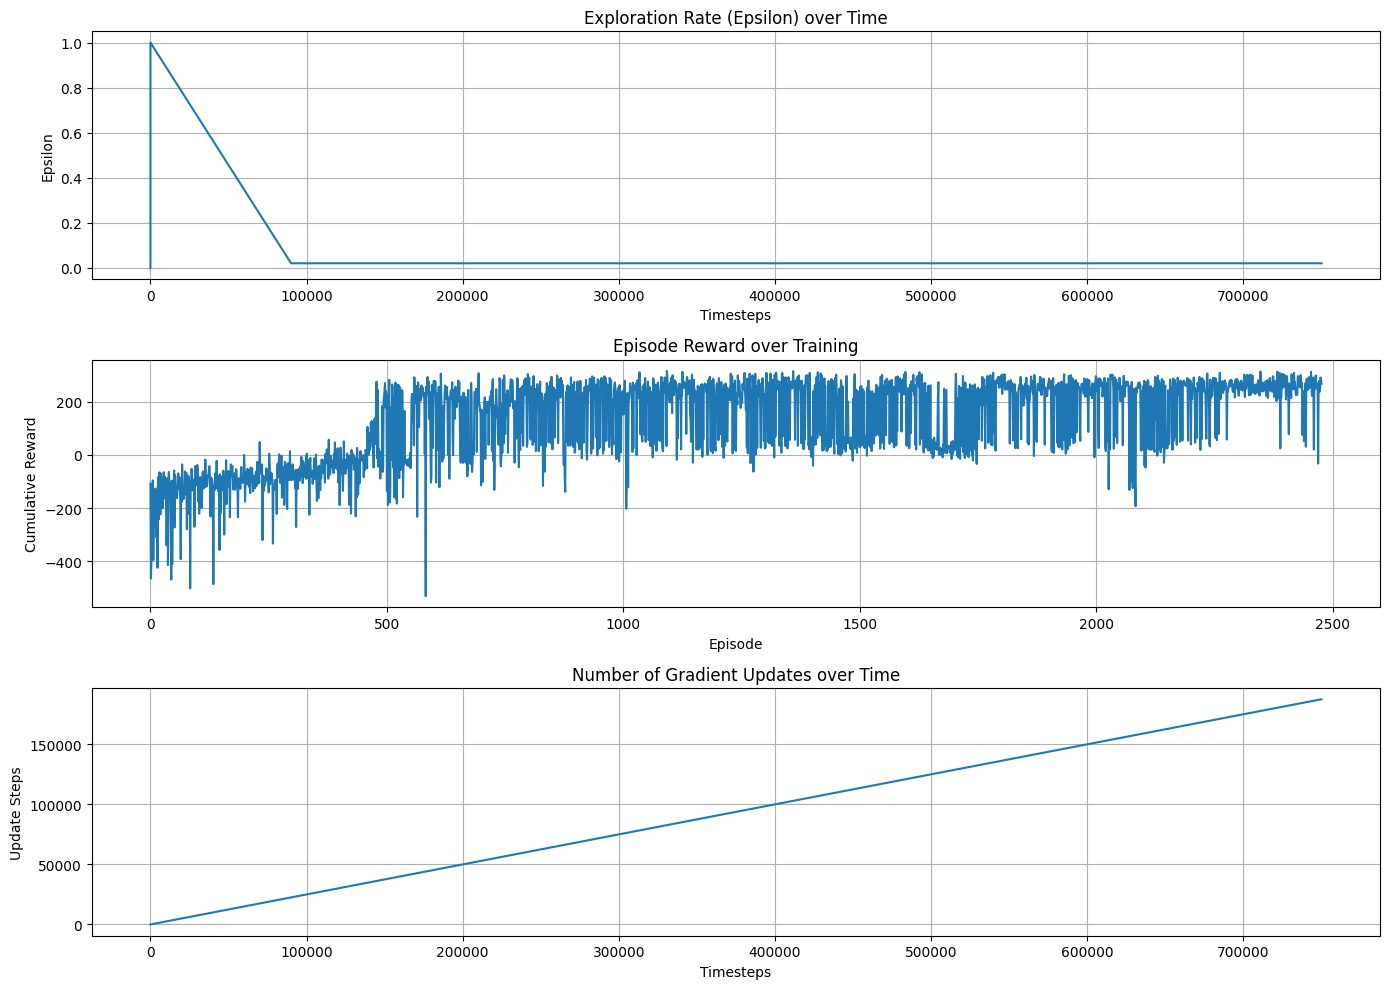

In [9]:
plt.figure(figsize=(14, 10))

# 1. EPSILON EVOLUTION
plt.subplot(3, 1, 1)
plt.plot(callback.epsilon_history)
plt.title("Exploration Rate (Epsilon) over Time")
plt.xlabel("Timesteps")
plt.ylabel("Epsilon")
plt.grid(True)

# 2. EPISODE REWARD EVOLUTION
plt.subplot(3, 1, 2)
plt.plot(callback.reward_history)
plt.title("Episode Reward over Training")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.grid(True)

# 3. NUMBER OF GRADIENT UPDATE STEPS
plt.subplot(3, 1, 3)
plt.plot(callback.update_steps)
plt.title("Number of Gradient Updates over Time")
plt.xlabel("Timesteps")
plt.ylabel("Update Steps")
plt.grid(True)

plt.tight_layout()
plt.show()

/home/logus/env/iscte/taap_p2/.venv_taap_p2/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward over 50 episodes: 209.12 ± 103.53
Episode length range: min = 105, max = 511


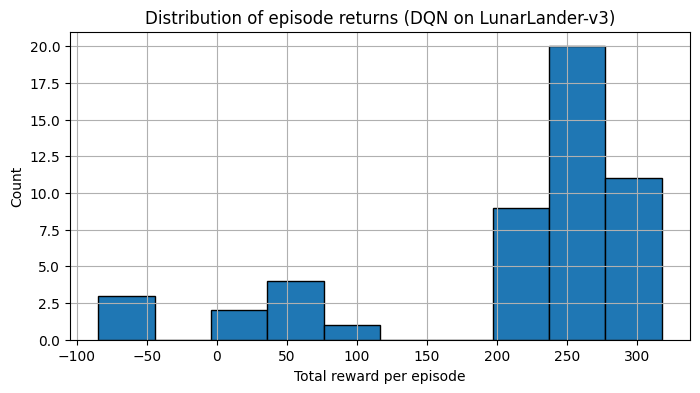

In [ ]:
# Create a new, clean, evaluation environment (non-vectorized)
eval_env = Monitor(gym.make(MODEL_NAME))

# run some episodes with the trained model, in the new environment
n_eval_episodes=50
episode_rewards, episode_lengths = evaluate_policy(
    model_dqn,
    eval_env,
    n_eval_episodes=50,
    deterministic=True,
    return_episode_rewards=True,  # return per-episode returns
)

# Compute summary statistics manually
mean_reward = np.mean(episode_rewards)
std_reward = np.std(episode_rewards)

print(f"Mean reward over {n_eval_episodes} episodes: {mean_reward:.2f} ± {std_reward:.2f}")
print(f"Episode length range: min = {int(np.min(episode_lengths))}, max = {int(np.max(episode_lengths))}")

# Visualize the distribution of episode returns
plt.figure(figsize=(8, 4))
plt.hist(episode_rewards, bins=10, edgecolor="black")
plt.title("Distribution of episode returns (DQN on " + MODEL_NAME + ")")
plt.xlabel("Total reward per episode")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Close the evaluation environment
eval_env.close()

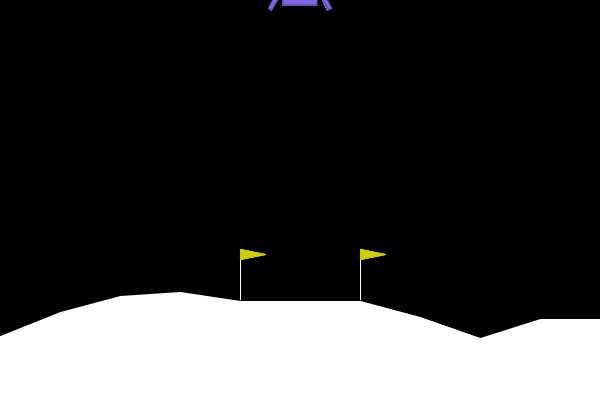

In [23]:
# Create a new environment for visualization only. Render_mode="rgb_array" so that env.render() returns actual image frames.
env = gym.make(MODEL_NAME, render_mode="rgb_array")

frames = [] # list to store each rendered frame of the episode

# Reset the environment to get the initial observation (state)
obs, info = env.reset()
done = False

# Run one full episode using the trained DQN agent
while not done:
    action, _ = model_dqn.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    # The episode ends either naturally (terminated) or by time limit (truncated)
    done = terminated or truncated
    frames.append(env.render())

env.close()

# Save all collected frames as an animated GIF
imageio.mimsave("dqn_lunarlander.gif", frames, duration=25)


# Presenting the image
Image(filename="dqn_lunarlander.gif")


In [12]:
print(f"Saving model to: {SAVE_MODEL_PATH}")
model_dqn.save(SAVE_MODEL_PATH)

Saving model to: ./outputs_DQN/model_dqn.zip


In [13]:
print("Loading the saved model...")
env2 = DummyVecEnv([make_env])
loaded_model = DQN.load(SAVE_MODEL_PATH, env=env2)

Loading the saved model...


In [14]:
obs = env2.reset()
done = False
total_reward = 0

while not done:
    action, _ = loaded_model.predict(obs, deterministic=True)
    obs, reward, done, info = env2.step(action)
    total_reward += reward

print(f"Total reward by the loaded model: {total_reward}")

Total reward by the loaded model: [262.34546]
